# wat is de connectie tussen vertragingen en het weer.

Dit noteboek is bedoelt voor AI4 semester Fontys ICT, eigen challenge. 

En is geschreven door mij, Anne Koppers. 

In dit notebook ga ik proberen te achterhallen of het weer een roll speelt met een vertraging in het openbaren trein verkeer.

Met deze datasets hoop ik te kunnen vinden of en waar er een goede verbinding is.


In mijn challenge ga ik gebruik maken van phyton pandas, een library om datasets in te laden. Ik ga daarnaast ook gebruik maken van plotly om het mooi aan te geven en sklearn voor de machine learning algoritmes.

Dependencies voor de challenge:

In [1]:
# dependances
import os
import numpy as np
# import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
# from geopy.exc import GeocoderTimedOut
# from geopy.geocoders import Nominatim
# from geopy.distance import geodesic

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer

datafolder = 'data/'

max_data = datetime(2023, 4, 1, 0, 0, 0)

# 📦 Data opzet

Nu ben ik op zoek gegaan naar datasets die van belang kunnen zijn in mijn opdracht. 

Dit zijn data sets die ik heb gekozen:
- [rijden de treinen. Treinarchief](https://www.rijdendetreinen.nl/open-data/treinarchief)
- [rijden de treinen. treinstoringen](https://www.rijdendetreinen.nl/open-data/treinstoringen)
- [rijden de treinen. treinstations](https://www.rijdendetreinen.nl/open-data/treinstations)
- [KNMI weerstations Uurwaarnemingen](https://www.daggegevens.knmi.nl/klimatologie/uurgegevens)
  <!-- benaming is overgenomen van de overheid -->
- [Train Stations in Europe](https://www.kaggle.com/datasets/headsortails/train-stations-in-europe)


In deze datasets staat het all het trein verkeer, het trein verkeer dat van gezegd word dat het een storing was, het weer in uren en de locatie van het trein station.

### 🚄 Treinarchief laden.

De code hieronder laad het trainarchief in. in dit treinarchief hebben we de volgende kolommen volgens [rijden de treinen](https://www.rijdendetreinen.nl/):
- `Service:RDT-ID` Dit ID wordt gebruikt voor deze rit. Het heeft geen nuttige betekenis buiten het uniek identificeren van een enkele rit op een enkele datum.
>Dit ID zal meerdere keren voorkomen in de CSV-bestanden omdat dit ID uniek is voor iedere rit. Er is ook een kolom Stop:RDT-ID met een uniek ID voor iedere stop.
- `Service:Date` De geplande datum voor deze rit.
>De rit-datum is niet altijd de logische datum. Bijvoorbeeld: een rit die vertrekt om 23:59 op 31 juli en aankomt om 02:00 op 1 augustus heeft een rit-datum van 31 juli. Vertragingen hebben geen invloed op de rit-datum.
- `Service:Type` Het soort trein, zoals Intercity, Sprinter of ICE International.
- `Service:Company` Vervoerder die deze rit uitvoert, zoals NS of Arriva.
- `Service:Train number` Het treinnummer (rit-nummer) voor deze rit identificeert deze rit uniek op deze datum. Dit nummer wordt soms ook gecommuniceerd naar reizigers (vooral voor internationale treinen). 
> Een enkele rit kan soms meerdere treinnummers hebben. Bijvoorbeeld wanneer een trein gesplitst wordt in twee delen, of wanneer een trein op een groot station halverwege van treinnummer verandert.
- `Service:Completely cancelled` Deze kolom is true wanneer alle stops van deze rit opgeheven zijn. Of met andere woorden: wanneer de trein helemaal niet rijdt.
- `Service:Partly cancelled` Deze kolom is true wanneer een of meer stops van deze rit opgeheven zijn. Of met andere woorden: wanneer de trein niet rijdt op een deel van het traject.
- `Service:Maximum delay` De hoogste vertraging (in minuten) van alle stops van deze rit.
- `Stop:RDT-ID` Unieke ID voor deze stop. Dit ID is uniek voor iedere stop in de dataset. Het heeft verder geen nuttige betekenis.
- `Stop:Station code` Code (verkorting) van de stationsnaam.
- `Stop:Station name` De naam van het station.
- `Stop:Arrival time` Geplande aankomsttijd in RFC 3339-formaat. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Arrival delay` Vertraging bij aankomst in minuten. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Arrival cancelled` Deze kolom is true wanneer de aankomst op deze stop opgeheven is. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Departure time` Geplande vertrektijd in RFC 3339-formaat. Deze kolom is leeg wanneer er geen vertrek gepland was.
- `Stop:Departure delay` Vertraging bij vertrek in minuten. Deze kolom is leeg wanneer er geen vertrek gepland was.
- `Stop:Departure cancelled` Deze kolom is true wanneer het vertrek op deze stop opgeheven is. Deze kolom is leeg wanneer er geen vertrek gepland was.


In de code laad ik de dataset in en verander ik de datum naar een datetime zodat ik hem dan kan verminderen naar het zoekgebied die ik op het moment heb in de weer dataset. daarna zet ik type en bedrijf naar kleine letters omdat de dataset handmatig soms is aangepast en dan worden hoofdletter vergeten.

ik gebruik deze dataset om te kijken welke treinen reden en welke treinen er vertraging hadden.

In [2]:
Train_trafic_2023 = pd.read_csv(datafolder + 'services-2023/services-2023.csv', sep=',', low_memory=False)

Train_trafic_2023['Service:Date'] = pd.to_datetime(Train_trafic_2023['Service:Date'], format="%Y-%m-%d")
Train_trafic_2023 = Train_trafic_2023[Train_trafic_2023['Service:Date'] < max_data]

Train_trafic_2023['Service:Type'] = Train_trafic_2023['Service:Type'].str.lower()
Train_trafic_2023['Service:Company'] = Train_trafic_2023['Service:Company'].str.lower()
Train_trafic_2023['Stop:Station name'] = Train_trafic_2023['Stop:Station name'].str.lower()

Train_trafic_2023['Stop:Arrival time'] = pd.to_datetime(Train_trafic_2023['Stop:Arrival time'])
Train_trafic_2023['Stop:Departure time'] = pd.to_datetime(Train_trafic_2023['Stop:Departure time'])

# Train_trafic_2023 = Train_trafic_2023[Train_trafic_2023['Service:Company'] == 'ns']

display(Train_trafic_2023.head())
display(Train_trafic_2023.info())

Service:RDT-ID Service:Date Service:Type Service:Company  \
0        10367702   2023-01-01    intercity              ns   
1        10367702   2023-01-01    intercity              ns   
2        10367702   2023-01-01    intercity              ns   
3        10367702   2023-01-01    intercity              ns   
4        10367702   2023-01-01    intercity              ns   

   Service:Train number  Service:Completely cancelled  \
0                  1410                         False   
1                  1410                         False   
2                  1410                         False   
3                  1410                         False   
4                  1410                         False   

   Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                     False                      3     93067918   
1                     False                      0     93067919   
2                     False                      0     93067920   
3                     False                      0     93067921   
4                     False                      0     93067922   

  Stop:Station code   Stop:Station name          Stop:Arrival time  \
0               RTD  rotterdam centraal                        NaT   
1                DT               delft  2023-01-01 02:13:00+01:00   
2                GV         den haag hs  2023-01-01 02:21:00+01:00   
3              LEDN     leiden centraal  2023-01-01 02:35:00+01:00   
4               SHL    schiphol airport  2023-01-01 02:56:00+01:00   

   Stop:Arrival delay Stop:Arrival cancelled        Stop:Departure time  \
0                 NaN                    NaN  2023-01-01 02:00:00+01:00   
1                 0.0                  False  2023-01-01 02:13:00+01:00   
2                 0.0                  False  2023-01-01 02:22:00+01:00   
3                 0.0                  False  2023-01-01 02:40:00+01:00   
4                 0.0                  False  2023-01-01 03:03:00+01:00   

   Stop:Departure delay Stop:Departure cancelled  
0                   1.0                    False  
1                   0.0                    False  
2                   0.0                    False  
3                   0.0                    False  
4                   0.0                    False

<class 'pandas.core.frame.DataFrame'>
Index: 5142250 entries, 0 to 11473990
Data columns (total 17 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Service:RDT-ID                int64         
 1   Service:Date                  datetime64[ns]
 2   Service:Type                  object        
 3   Service:Company               object        
 4   Service:Train number          int64         
 5   Service:Completely cancelled  bool          
 6   Service:Partly cancelled      bool          
 7   Service:Maximum delay         int64         
 8   Stop:RDT-ID                   int64         
 9   Stop:Station code             object        
 10  Stop:Station name             object        
 11  Stop:Arrival time             object        
 12  Stop:Arrival delay            float64       
 13  Stop:Arrival cancelled        object        
 14  Stop:Departure time           object        
 15  Stop:Departure delay          float6

None

### 🌥️ KNMI Uurwaarnemingen laden

In de code hieronder laad ik de Uurwaarnemingen van het weer in. Dit is waarom merendeels van het project alleen over de eerste 2 maanden van het project gaan. <p>
In de dataset van het weer hebben we:
- `STN` dit is het weer station nummer
- `YYYYMMDD` datum (YYYY=jaar;MM=maand;DD=dag)
- `start_time` tijd (HH=uur; UT.12 UT=13 MET; 14 MEZT. Uurvak 05 loopt van 04.00 UT tot 5.00 UT)
- `DD` Windrichting (in graden) gemiddeld over de laatste 10 minuten van het afgelopen uur (360=noord; 90=oost; 180=zuid; 270=west; 0=windstil 990=veranderlijk.
- `FH` Uurgemiddelde windsnelheid (in 0.1 m/s).
- `FF` Windsnelheid (in 0.1 m/s) gemiddeld over de laatste 10 minuten van het afgelopen uur.
- `FX` Hoogste windstoot (in 0.1 m/s) over het afgelopen uurvak.
- `temp` Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming.
- `T10N` Minimumtemperatuur (in 0.1 graden Celsius) op 10 cm hoogte in de afgelopen 6 uur.
- `TD` Dauwpunts-temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming.
- `SQ` Duur van de zonneschijn (in 0.1 uren) per uurvak; berekend uit globale straling  (-1 for <0.05 uur).
- `Q` Globale straling (in J/cm2) per uurvak.
- `DR` Duur van de neerslag (in 0.1 uur) per uurvak.
- `RH` Uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm).
- `P` Luchtdruk (in 0.1 hPa) herleid naar zeeniveau; tijdens de waarneming.
- `VV` Horizontaal zicht tijdens de waarneming (0=minder dan 100m; 1=100-200m; 2=200-300m;...; 49=4900-5000m; 50=5-6km; 56=6-7km; 57=7-8km; ...; 79=29-30km; 80=30-35km; 81=35-40km;...; 89=meer dan 70km).
- `N` Bewolking (bedekkingsgraad van de bovenlucht in achtsten); tijdens de waarneming (9=bovenlucht onzichtbaar).
- `U` Relatieve vochtigheid (in procenten) op 1.50 m hoogte tijdens de waarneming.
- `WW` Weercode (00-99); visueel(WW) of automatisch(WaWa) waargenomen; voor het actuele weer of het weer in het afgelopen uur.
- `IX` Weercode indicator voor de wijze van waarnemen op een bemand of automatisch station (1=bemand gebruikmakend van code uit visuele waarnemingen; 2;3=bemand en weggelaten (geen belangrijk weersverschijnsel; geen gegevens); 4=automatisch en opgenomen (gebruikmakend van code uit visuele waarnemingen); 5;6=automatisch en weggelaten (geen belangrijk weersverschijnsel; geen gegevens); 7=automatisch gebruikmakend van code uit automatische waarnemingen).
- `M` Mist 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `R` Regen 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `S` Sneeuw 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `O` Onweer 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `Y` IJsvorming 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.


Hier laad ik het weer in dat en zet de start_time of de start tijd naar een datetime. Daarbij combineer ik twee kolommen om een datum en tijd in 1 kolom te krijgen.

Ik gebruik deze dataset om het weer van een bepaalde datum en station nummer te krijgen.

In [3]:
weather_2023 = pd.read_csv(datafolder + '2023-jan-mar.csv', sep=',', low_memory=False, encoding='utf-8', skiprows=80)

weather_2023['start_time'] = weather_2023['start_time'].astype(str) + ' ' + (weather_2023['HH'] - 1).astype(str) + ':00:00'

weather_2023['start_time'] = pd.to_datetime(weather_2023['start_time'], format="%Y%m%d %H:%M:%S").dt.tz_localize('Europe/Amsterdam', nonexistent='shift_forward')

#  drop columns that are not needed
# weather_2023 = weather_2023.drop(columns=['HH', 'WW', 'IX', 'FH', 'FX', 'TD', 'SQ', 'RH'])
weather_2023 = weather_2023.drop(columns=['HH'])

display(weather_2023.head())
display(weather_2023.info())    

STN                start_time     DD     FH     FF     FX  temp  T10N  TD  \
0  209 2023-01-01 00:00:00+01:00  220.0  140.0  150.0  170.0   NaN   NaN NaN   
1  209 2023-01-01 01:00:00+01:00  220.0  130.0  130.0  170.0   NaN   NaN NaN   
2  209 2023-01-01 02:00:00+01:00  240.0  140.0  130.0  200.0   NaN   NaN NaN   
3  209 2023-01-01 03:00:00+01:00  220.0  120.0  130.0  170.0   NaN   NaN NaN   
4  209 2023-01-01 04:00:00+01:00  230.0  130.0  140.0  170.0   NaN   NaN NaN   

   SQ  ...  VV   N   U  WW  IX   M   R   S   O   Y  
0 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
1 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
2 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
3 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
4 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  

[5 rows x 24 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99360 entries, 0 to 99359
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype                           
---  ------      --------------  -----                           
 0   STN         99360 non-null  int64                           
 1   start_time  99360 non-null  datetime64[ns, Europe/Amsterdam]
 2   DD          96861 non-null  float64                         
 3   FH          96860 non-null  float64                         
 4   FF          96861 non-null  float64                         
 5   FX          96860 non-null  float64                         
 6   temp        73440 non-null  float64                         
 7   T10N        12240 non-null  float64                         
 8   TD          73440 non-null  float64                         
 9   SQ          69120 non-null  float64                         
 10  Q           69120 non-null  float64                         
 11  DR          71279 non-null  

None

De weer dataset bestaat uit 2 datasets. de gene hierboven die voor de gegevens uit de weer stations.
En de gene hieronder die gaat over de weer station Locaties.


De weer station locatie dataset heeft de kolommen:
- `STN` dit is het weer station nummer.
- `LON(east)` dit is de longitude van het weer station.
- `LAT(north)` dit is de latitude van het weer station.
- `ALT(m)` dit is de hoogte waarop het station staat.
- `NAME` de naam van waar het weer station staat.

Met deze gegevens hoop ik te achterhalen wat het weer was het station van aankomst.

De dataset van het weer heeft de locatie op basis van station nummer.

In [4]:
weather_station_location = pd.read_csv(datafolder + 'Weather-stations-loc.csv', sep=',', low_memory=False, encoding='utf-8')
display(weather_station_location.head())
display(weather_station_location.info())

STN  LON(east)  LAT(north)  ALT(m)          NAME
0  209      4.518      52.465     0.0        IJmond
1  210      4.430      52.171    -0.2  ValkenburgZh
2  215      4.437      52.141    -1.1   Voorschoten
3  225      4.555      52.463     4.4      IJmuiden
4  235      4.781      52.928     1.2        DeKooy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STN         50 non-null     int64  
 1   LON(east)   50 non-null     float64
 2   LAT(north)  50 non-null     float64
 3   ALT(m)      50 non-null     float64
 4   NAME        50 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ KB


None

### 🏟️ trein station 

In de dataset hieronder zitten alle trein stations van Europa. Ik zal minder nodig hebben dus zal met de country alleen Nederland, duisterland en België gaan houden. Dit is ook omdat mijn andere datasets niet Verder kijken dan die locaties.

In deze dataset zit:
- `id` de primary sleutel van de data.
- `name` Naam van het station zoals het lokaal bekend is. Deze namen bevatten accenten en andere speciale tekens.
- `name_norm` De gelatiniseerde versie van de naam.
- `uic` International Union of Railways (UIC) code.
- `latitude` Coordinates
- `longitude` Coordinates
- `parent_station_id` A station can belong to a meta station whose `id` is this value.
- `country` Landcodes in ISO 3166-1 alpha-2 formaat (2 cijfers).
- `time_zone` Continent/Land ISO-codes. Deze lijken equivalent te zijn aan Olson-namen (bijvoorbeeld “Europe/Berlin”).
- `is_city` Gemarkeerd als “onbetrouwbaar” in de bron dataset.
- `is_main_station` 
- `is_airport` 
- `entur_id` 
- `entur_is_enabled` 

Ik zal deze dataset gebruiken om de locaties van de trein stations te vinden. <p>
En aangezien ik alleen de locaties hoef te hebben zal ik die ook allen onthouden. naast de belangrijke data zoals Namen die het kunnen zijn en in welk land ze zitten.

met de hulp van deze gegevens hoop ik de gaten in mijn gegevens te vullen. 


In [5]:
train_station_locations = pd.read_csv(datafolder + 'train_stations_europe.csv', low_memory=False, encoding='utf-8')

train_station_locations = train_station_locations.drop(columns=['id', 'uic', 'parent_station_id', 'time_zone', 'is_city', 'is_main_station', 'is_airport', 'entur_id', 'entur_is_enabled'])

# europa_train_station_locations['country'] = pd.Categorical(europa_train_station_locations['country'], categories=['NL', 'DE', 'BE'], ordered=True)
# europa_train_station_locations = europa_train_station_locations[europa_train_station_locations['country'].notna()]

train_station_locations['name'] = train_station_locations['name'].str.lower()

display(train_station_locations.head())
display(train_station_locations.info())

name                name_norm   latitude  longitude  \
0  château-arnoux—st-auban  Chateau-Arnoux-St-Auban  44.081790   6.001625   
1  château-arnoux—st-auban  Chateau-Arnoux-St-Auban  44.061565   5.997373   
2    château-arnoux mairie    Chateau-Arnoux Mairie  44.063863   6.011248   
3          digne-les-bains          Digne-les-Bains  44.350000   6.350000   
4          digne-les-bains          Digne-les-Bains  44.088710   6.222982   

  country  
0      FR  
1      FR  
2      FR  
3      FR  
4      FR

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64037 entries, 0 to 64036
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       64036 non-null  object 
 1   name_norm  64036 non-null  object 
 2   latitude   62142 non-null  float64
 3   longitude  62142 non-null  float64
 4   country    64037 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.4+ MB


None

Ik ben er later achter gekomen dat rijden de treinen ook de trein stations meegeeft dus ik zal deze dataset gebruiken.

Deze dataset hoop ik te kunnen gebruiken in een manier waarop ik kan vergelijken waar een station zich begeeft.

In deze dataset staat:
- `rdt_id` Intern ID gebruikt door Rijden de Treinen.
- `code` De unieke verkorting (afkorting) van het station. Meestal is het een afkorting van de stationsnaam, maar de naam is niet altijd herkenbaar (bijvoorbeeld de meeste stations in Den Haag). Een stationcode is maximaal 8 tekens lang.
- `uic` De UIC-code van een station. Dit is een internationaal uniek identificatienummer voor stations. Nederlandse stations hebben een UIC-code die begint met 84 (bijvoorbeeld 8400058 voor Amsterdam Centraal).
- `name_short` Korte version van de stationsnaam. Vaak wordt een groot deel van de stationsnaam weggelaten (bijvoorbeeld Sciencepark in plaats van Amsterdam Science Park).
- `name_medium` De middellange versie van de stationsnaam. Deze versie van de stationsnaam wordt vaak gebruikt wanneer er geen ruimte is voor de volledige naam, maar kan ook niet alle naamelementen bevatten (bijvoorbeeld Science Park in plaats van Amsterdam Science Park).
- `name_long` De lange (of volledige) stationsnaam.
- `slug` Unieke naam voor het station, in kleine letters en zonder spaties. Dit is hetzelfde als de URL van de stationspagina op de Rijden de Treinen website.
- `country` Het land waarin het station zich bevindt. NL is Nederland, D is Duitsland, B is België, F is Frankrijk, A is Oostenrijk, CH is Zwitserland, GB is het Verenigd Koninkrijk.
- `type` Het soort station. Mogelijke waarden zijn (van groot naar klein station): megastation, knooppuntIntercitystation, intercitystation, knooppuntSneltreinstation, sneltreinstation, knooppuntStoptreinstation, stoptreinstation, facultatiefStation. De categorie knooppunt impliceert dat deze stations bedoeld zijn voor het overstappen op een andere trein. Een facultatiefStation is een station waar normaal gesproken geen treinen stoppen, behalve bij speciale gelegenheden (zoals voetbalwedstrijden).
- `geo_lat` Breedtegraad van het station, in decimale graden.
- `geo_lng` Lengtegraad van het station, in decimale graden.

In [6]:
train_station_locations = pd.read_csv(datafolder + 'stations-2023-09.csv', low_memory=False, encoding='utf-8')

display(train_station_locations.head())
display(train_station_locations.info())

id  code      uic  name_short       name_medium              name_long  \
0  266    HT  8400319   Den Bosch  's-Hertogenbosch       's-Hertogenbosch   
1  269   HTO  8400320  Dn Bosch O  's-Hertogenb. O.  's-Hertogenbosch Oost   
2  227   HDE  8400388    't Harde          't Harde               't Harde   
3    8  AHBF  8015345      Aachen        Aachen Hbf             Aachen Hbf   
4  818    AW  8015199    Aachen W       Aachen West            Aachen West   

                   slug country                       type    geo_lat  \
0       s-hertogenbosch      NL  knooppuntIntercitystation  51.690480   
1  s-hertogenbosch-oost      NL           stoptreinstation  51.700554   
2               t-harde      NL           stoptreinstation  52.409168   
3            aachen-hbf       D  knooppuntIntercitystation  50.767800   
4           aachen-west       D           stoptreinstation  50.780360   

    geo_lng  
0  5.293620  
1  5.318333  
2  5.893611  
3  6.091499  
4  6.070715

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           591 non-null    int64  
 1   code         590 non-null    object 
 2   uic          591 non-null    int64  
 3   name_short   591 non-null    object 
 4   name_medium  591 non-null    object 
 5   name_long    591 non-null    object 
 6   slug         591 non-null    object 
 7   country      591 non-null    object 
 8   type         591 non-null    object 
 9   geo_lat      591 non-null    float64
 10  geo_lng      591 non-null    float64
dtypes: float64(2), int64(2), object(7)
memory usage: 50.9+ KB


None

# 📃 Sample de data

Om even naar de data te kijken ga ik 20 van iedere dataset hieronder laden. Dit is om te kijken of het wel goed is ingeladen en dat de data er een beetje werkzaam uitziet.

### 🚄 Treinarchief laden.

Hier laad ik de samples van het trein verkeer.
En ik laat daaronder ook even zien of er NULL variables zitten in de dataset. Bij dit treinarchief maken NULL variabelen niet out want dat heeft namelijk ook een belangrijke reden. Deze reden is dat een NULL gewoon betekend dat het niet voorkwam en aangezien een vertraging die NULL is is gewoon dat er geen vertraging is vermeld.

In [7]:
sample_size = 20

display(Train_trafic_2023.sample(sample_size))
display(Train_trafic_2023.isna().sum())

Service:RDT-ID Service:Date          Service:Type Service:Company  \
1515474        10525548   2023-01-28              sprinter              ns   
3643851        10758976   2023-03-06             intercity              ns   
4070367        10804005   2023-03-13             intercity              ns   
3066581        10692487   2023-02-24             intercity              ns   
1916654        10568398   2023-02-03              sprinter              ns   
3649485        10759527   2023-03-06              sprinter              ns   
1623707        10538461   2023-01-30              sprinter              ns   
2825625        10667422   2023-02-20              sprinter              ns   
4675010        10865524   2023-03-24             intercity              ns   
2329511        10612804   2023-02-11  stopbus i.p.v. trein              ns   
630373         10432114   2023-01-12             stoptrein          arriva   
1042930        10475467   2023-01-19             sneltrein          arriva   
2541703        10636390   2023-02-15             stoptrein      valleilijn   
378297         10406618   2023-01-08              sprinter              ns   
3426635        10735079   2023-03-02              sprinter        blauwnet   
4768359        10875612   2023-03-25              sprinter              ns   
1226009        10495496   2023-01-23             stoptrein              db   
615962         10430661   2023-01-12             stoptrein          arriva   
4220947        10819262   2023-03-16             stoptrein        eurobahn   
1574029        10531990   2023-01-29      intercity direct          ns int   

         Service:Train number  Service:Completely cancelled  \
1515474                  4016                         False   
3643851                  3137                         False   
4070367                  1875                         False   
3066581                  3619                         False   
1916654                  7680                         False   
3649485                  5738                         False   
1623707                  6131                         False   
2825625                  4319                         False   
4675010                  2245                         False   
2329511                982094                          True   
630373                  37755                         False   
1042930                 37380                         False   
2541703                 31406                         False   
378297                   4645                         False   
3426635                  7938                          True   
4768359                  7378                         False   
1226009                 20262                         False   
615962                  17832                         False   
4220947                 20366                         False   
1574029                  9231                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
1515474                     False                      0     94588229   
3643851                      True                      0     96716675   
4070367                     False                      0     97143121   
3066581                     False                      0     96139387   
1916654                     False                      0     94989449   
3649485                      True                      0     96722310   
1623707                     False                      0     94696511   
2825625                     False                      0     95898427   
4675010                     False                      0     97747809   
2329511                      True                      0     95402302   
630373                      False                      0     93703172   
1042930                     False                      0     94115712   
2541703                      True                      0     95614515   
378297                  

Service:RDT-ID                       0
Service:Date                         0
Service:Type                         0
Service:Company                      0
Service:Train number                 0
Service:Completely cancelled         0
Service:Partly cancelled             0
Service:Maximum delay                0
Stop:RDT-ID                          0
Stop:Station code                 6632
Stop:Station name                    0
Stop:Arrival time               551049
Stop:Arrival delay              551049
Stop:Arrival cancelled          551049
Stop:Departure time             550943
Stop:Departure delay            550943
Stop:Departure cancelled        550943
dtype: int64

### 🌥️ KNMI Uurwaarnemingen laden
Hieronder laad ik de samples can de weerstations, Em de weer station locaties. Dit heb ik nodig om later te kijken welk weer station het dichts bij het trein station is. 
En daaronder kijk ik hoeveel NULL variables er zijn. Dit betekend bij bijna alle kolommen dat een weer station geen sensor ervoor heeft. 
T10N is anders want deze wordt elk 6 uur opgenomen daardoor is alle andere rows die ertussen zitten NULL. Dit is natuurlijk als het weer station een temperatuur sensor heeft.

In [8]:
display(weather_2023.sample(sample_size))
display(weather_station_location.sample(sample_size))


display(weather_2023.isna().sum())
display(weather_station_location.isna().sum())


STN                start_time     DD     FH     FF     FX   temp  T10N  \
6499   235 2023-01-01 19:00:00+01:00  170.0   40.0   50.0   70.0  104.0   NaN   
32226  270 2023-03-24 18:00:00+01:00  220.0   70.0   70.0  110.0   93.0   NaN   
27320  267 2023-02-28 08:00:00+01:00  170.0   50.0   40.0   60.0   21.0   NaN   
4408   225 2023-01-04 16:00:00+01:00  230.0  140.0  140.0  180.0    NaN   NaN   
7499   235 2023-02-12 11:00:00+01:00  260.0   40.0   30.0   50.0   81.0  48.0   
32748  273 2023-01-15 12:00:00+01:00  240.0   90.0   90.0  180.0   74.0   NaN   
62877  315 2023-01-10 21:00:00+01:00  200.0  120.0  130.0  160.0    NaN   NaN   
49943  286 2023-01-11 23:00:00+01:00  240.0  110.0   90.0  170.0   81.0  68.0   
54206  308 2023-01-09 14:00:00+01:00  290.0  100.0  100.0  130.0    NaN   NaN   
23286  258 2023-03-12 06:00:00+01:00  170.0   80.0   80.0  110.0    NaN   NaN   
15438  249 2023-01-14 06:00:00+01:00  190.0   80.0   70.0  110.0   62.0   NaN   
9904   240 2023-02-22 16:00:00+01:00  260.0   40.0   40.0   70.0   83.0   NaN   
87305  356 2023-02-07 17:00:00+01:00  100.0   20.0   20.0   20.0    2.0 -30.0   
75720  340 2023-01-06 00:00:00+01:00  220.0   50.0   50.0  100.0  109.0   NaN   
72373  324 2023-02-15 13:00:00+01:00  220.0   30.0   40.0   50.0    NaN   NaN   
29637  269 2023-03-06 21:00:00+01:00  250.0   70.0   60.0  120.0   43.0   NaN   
95352  380 2023-01-14 00:00:00+01:00  220.0   60.0   60.0  100.0   66.0   NaN   
20679  257 2023-02-21 15:00:00+01:00    NaN    NaN    NaN    NaN   72.0   NaN   
73611  330 2023-01-08 03:00:00+01:00  200.0   80.0   80.0  120.0   81.0   NaN   
70465  323 2023-02-26 01:00:00+01:00   30.0   40.0   50.0   80.0   38.0   NaN   

         TD   SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
6499   86.0  0.0  ...  61.0  8.0  89.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
32226  67.0  0.0  ...  70.0  2.0  84.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
27320  18.0  0.0  ...  56.0  8.0  98.0  52.0   7  0.0  1.0  0.0  0.0  0.0  
4408    NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
7499   36.0  0.0  ...  75.0  8.0  73.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
32748  37.0  3.0  ...  75.0  NaN  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
62877   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
49943  50.0  0.0  ...   NaN  NaN  81.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
54206   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
23286   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
15438  53.0  0.0  ...  59.0  NaN  93.0  52.0   7  0.0  1.0  0.0  0.0  0.0  
9904   67.0  0.0  ...  57.0  8.0  89.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
87305 -25.0  0.0  ...   NaN  NaN  81.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
75720  82.0  NaN  ...  70.0  8.0  83.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
72373   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
29637  34.0  0.0  ...  58.0  8.0  94.0  52.0   7  0.0  1.0  0.0  0.0  0.0  
95352  38.0  0.0  ...  64.0  7.0  82.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
20679  69.0  0.0  ...   NaN  NaN  97.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
73611  49.0  0.0  ...   NaN  NaN  79.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
70465 -10.0  0.0  ...   NaN  NaN  70.0   NaN   6  NaN  NaN  NaN  NaN  NaN  

[20 rows x 24 columns]

STN  LON(east)  LAT(north)  ALT(m)             NAME
21  279      6.574      52.750    15.8        Hoogeveen
39  340      4.342      51.449    19.2      Woensdrecht
34  319      3.861      51.226     1.7        Westdorpe
30  312      3.622      51.768     0.0    Oosterschelde
49  391      6.197      51.498    19.5            Arcen
8   249      4.979      52.644    -2.4         Berkhout
43  350      4.936      51.566    14.9      Gilze-Rijen
42  348      4.926      51.970    -0.7       CabauwMast
46  375      5.707      51.659    22.0           Volkel
1   210      4.430      52.171    -0.2     ValkenburgZh
4   235      4.781      52.928     1.2           DeKooy
6   242      4.921      53.241    10.8         Vlieland
0   209      4.518      52.465     0.0           IJmond
45  370      5.377      51.451    22.6        Eindhoven
48  380      5.762      50.906   114.3       Maastricht
25  286      7.150      53.196    -0.2      NieuwBeerta
28  310      3.596      51.442     8.0       Vlissingen
31  313      3.242      51.505     0.0  VlaktevanDeRaan
23  283      6.657      52.069    29.1           Hupsel
38  331      4.193      51.480     0.0           Tholen

STN               0
start_time        0
DD             2499
FH             2500
FF             2499
FX             2500
temp          25920
T10N          87120
TD            25920
SQ            30240
Q             30240
DR            28081
RH            28080
P             47520
VV            45361
N             56160
U             25920
WW            73164
IX                0
M             45415
R             45415
S             45415
O             45415
Y             45415
dtype: int64

STN           0
LON(east)     0
LAT(north)    0
ALT(m)        0
NAME          0
dtype: int64

### 🏟️ Trein station 
Hier laad ik de samples van de trein stations. en het ziet ernaar uit dat ik geen nulls heb. dus dat is goed. 

In [9]:
display(train_station_locations.sample(sample_size))

display(train_station_locations.isna().sum())

id    code      uic  name_short       name_medium  \
464  649    ESEB  8021120      Selm-B      Selm-Beifang   
488  431      SM  8400583     Swalmen           Swalmen   
385  790     FNU  8894714  Nieuwkerke  Nieuwkerken-Waas   
68    59  BASELB  8014431   Basel Bad      Basel Bad Bf   
256  247      HM  8400313     Helmond           Helmond   
533  495     VST  8400659   Voorschtn       Voorschoten   
103   85     BMR  8400128     Boxmeer           Boxmeer   
506  718    UTLR  8400607  LeidscheRn     Leidsche Rijn   
66    89     BNN  8400092  Barnevld N   Barneveld Noord   
276  258     HON  8400328      Holten            Holten   
315  286     KMA  8400368   Krommenie    Krommenie-Ass.   
443  401     RLB  8400542  Lombardije       Lombardijen   
264  234    HGLO  8400312   Hengelo O      Hengelo Oost   
575  804     ZZS  8400364   Zaanse S.     Zaanse Schans   
144  215     GVM  8400278  Mariahoeve        Mariahoeve   
89   567    KBOI  8015128    Boisheim          Boisheim   
146  525     YPB  8400379    Ypenburg          Ypenburg   
26    24    AMFS  8400054  Schothorst        Schothorst   
191  178      ES  8400212    Enschede          Enschede   
184  184     EST  8400207        Elst              Elst   

                  name_long                    slug country  \
464            Selm-Beifang            selm-beifang       D   
488                 Swalmen                 swalmen      NL   
385        Nieuwkerken-Waas        nieuwkerken-waas       B   
68             Basel Bad Bf            basel-bad-bf       D   
256                 Helmond                 helmond      NL   
533             Voorschoten             voorschoten      NL   
103                 Boxmeer                 boxmeer      NL   
506   Utrecht Leidsche Rijn   utrecht-leidsche-rijn      NL   
66          Barneveld Noord         barneveld-noord      NL   
276                  Holten                  holten      NL   
315    Krommenie-Assendelft    krommenie-assendelft      NL   
443   Rotterdam Lombardijen   rotterdam-lombardijen      NL   
264            Hengelo Oost            hengelo-oost      NL   
575  Zaandijk Zaanse Schans  zaandijk-zaanse-schans      NL   
144     Den Haag Mariahoeve     den-haag-mariahoeve      NL   
89                 Boisheim                boisheim       D   
146       Den Haag Ypenburg       den-haag-ypenburg      NL   
26    Amersfoort Schothorst   amersfoort-schothorst      NL   
191                Enschede                enschede      NL   
184                    Elst                    elst      NL   

                          type    geo_lat   geo_lng  
464           stoptreinstation  51.692947  7.454829  
488           stoptreinstation  51.235820  6.032280  
385           stoptreinstation  51.185556  4.185832  
68            stoptreinstation  47.568150  7.607300  
256  knooppuntIntercitystation  51.475555  5.661944  
533           stoptreinstation  52.125278  4.432500  
103  knooppuntStoptreinstation  51.644522  5.939033  
506           stoptreinstation  52.098960  5.065230  
66            stoptreinstation  52.161388  5.598055  
276           stoptreinstation  52.283890  6.420278  
315           stoptreinstation  52.495110  4.754170  
443           stoptreinstation  51.880001  4.531389  
264           stoptreinstation  52.268890  6.819445  
575  knooppuntStoptreinstation  52.469166  4.805000  
144           stoptreinstation  52.090557  4.369444  
89            intercitystation  51.274323  6.274591  
146           stoptreinstation  52.055279  4.392222  
26            stoptreinstation  52.174822  5.403889  
191  knooppuntIntercitystation  52.222500  6.890000  
184  knooppuntStoptreinstation  51.916943  5.855000

id             0
code           1
uic            0
name_short     0
name_medium    0
name_long      0
slug           0
country        0
type           0
geo_lat        0
geo_lng        0
dtype: int64

# 🔍 vooronderzoek

Aangezien ik meerdere datasets heb moet ik als eerst even kijken waar de vertragingen zitten.

Hiervoor maak ik een pie chard en kijk ik wat er de vertragingen zijn.

### 🚄 Trein verkeer 
In het trein verkeer is het belangrijk om te weten dat als er null staat dan heeft het nog steeds een betekenis. 

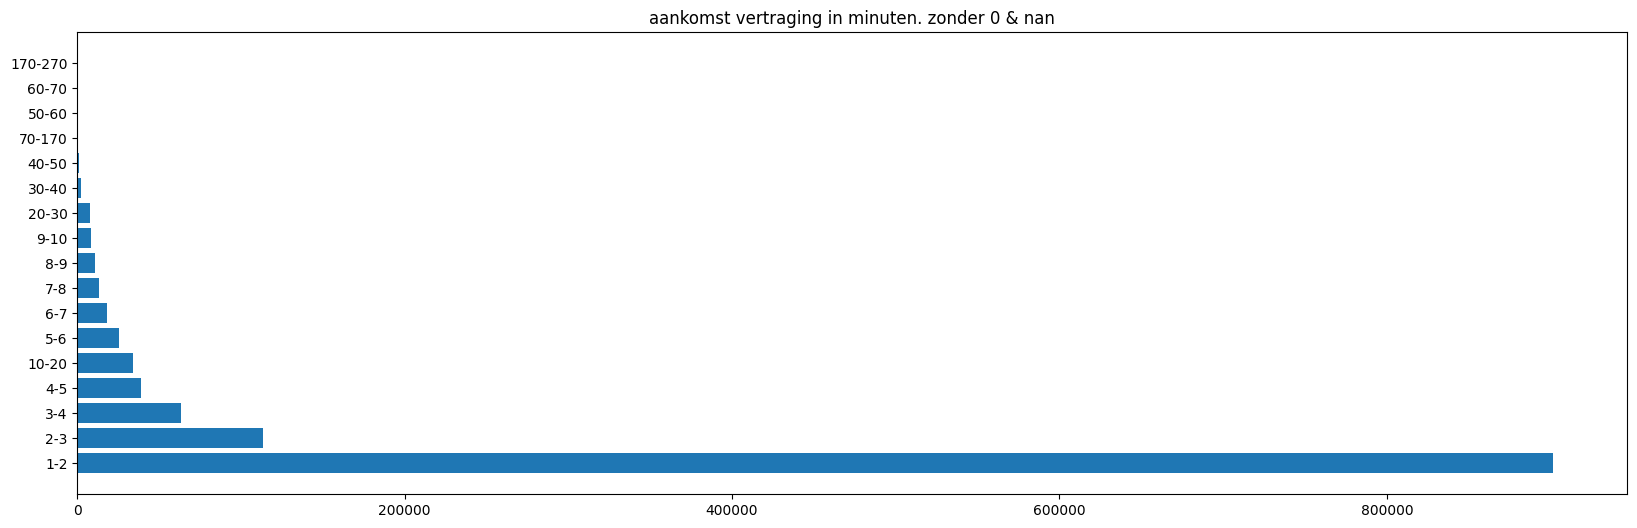

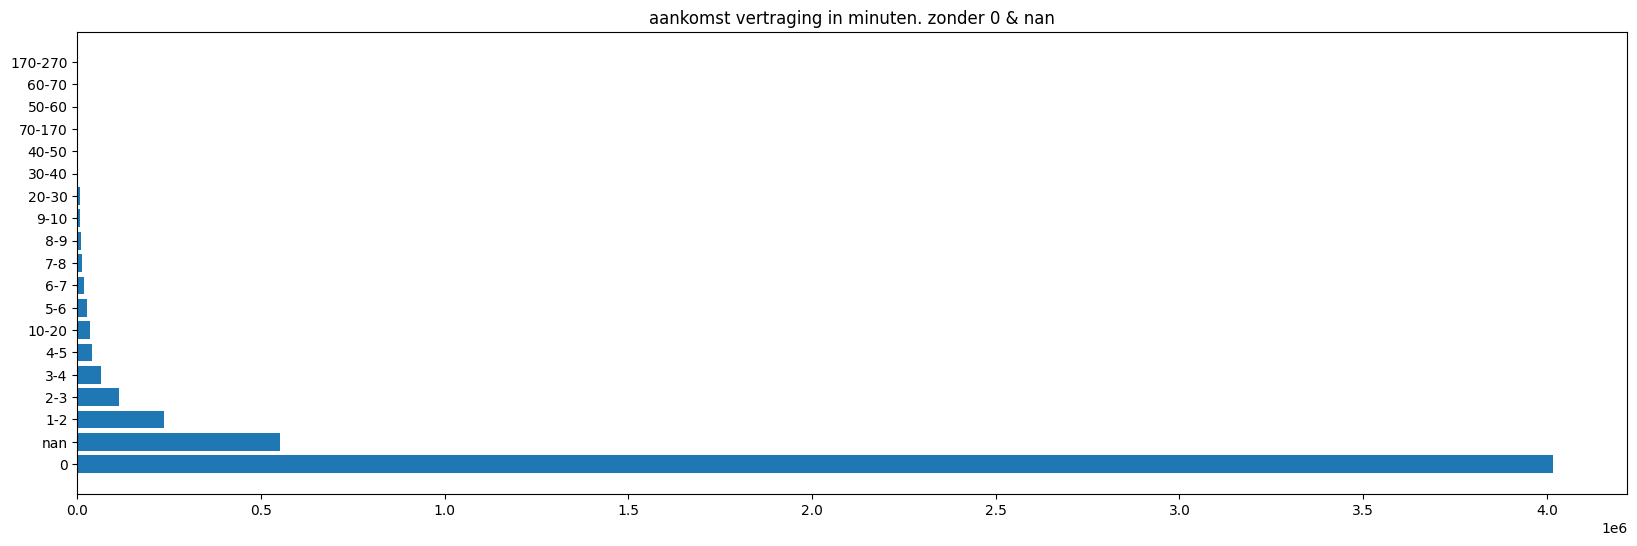

In [10]:
bins =  list(range(1, 10, 1)) + list(range(10, 70, 10)) + list(range(70, int(Train_trafic_2023['Stop:Departure delay'].max()) +100, 100))

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

counts = pd.cut(Train_trafic_2023['Stop:Departure delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

labels = ['0'] + labels

bins = [0] + bins 

counts = pd.cut(Train_trafic_2023['Stop:Departure delay'], bins=bins, labels=labels, include_lowest=True).astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

in de chards hierboven is in te lezen dat de meeste treinen op tijd weggaan van hun locatie. houd nogmaals rekening dat 0 en nan allebei zeggen dat er geen vertraging vermeld is.

en als ik de nan en 0 weg haal is de vertraging voornamelijk binnen de 10 minuten.

maar dit hierboven is alleen de vertrek vertraging. hieronder heb ik de aankomst vertraging op de zelfde manier gedaan.

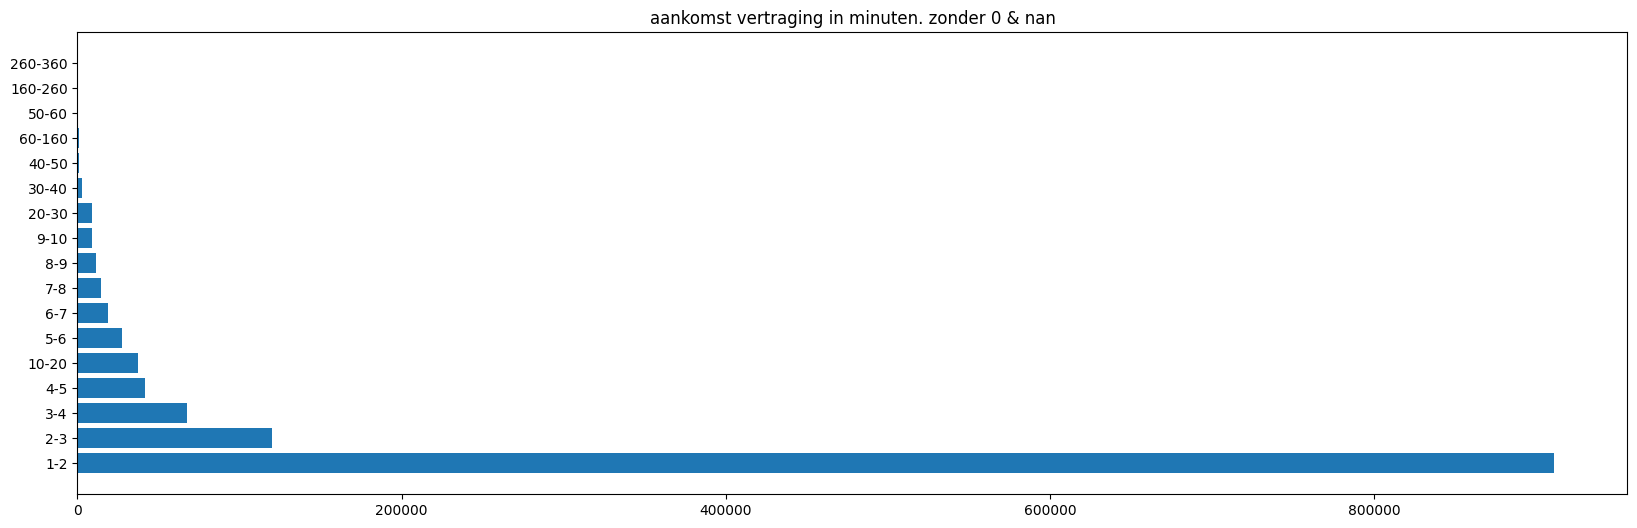

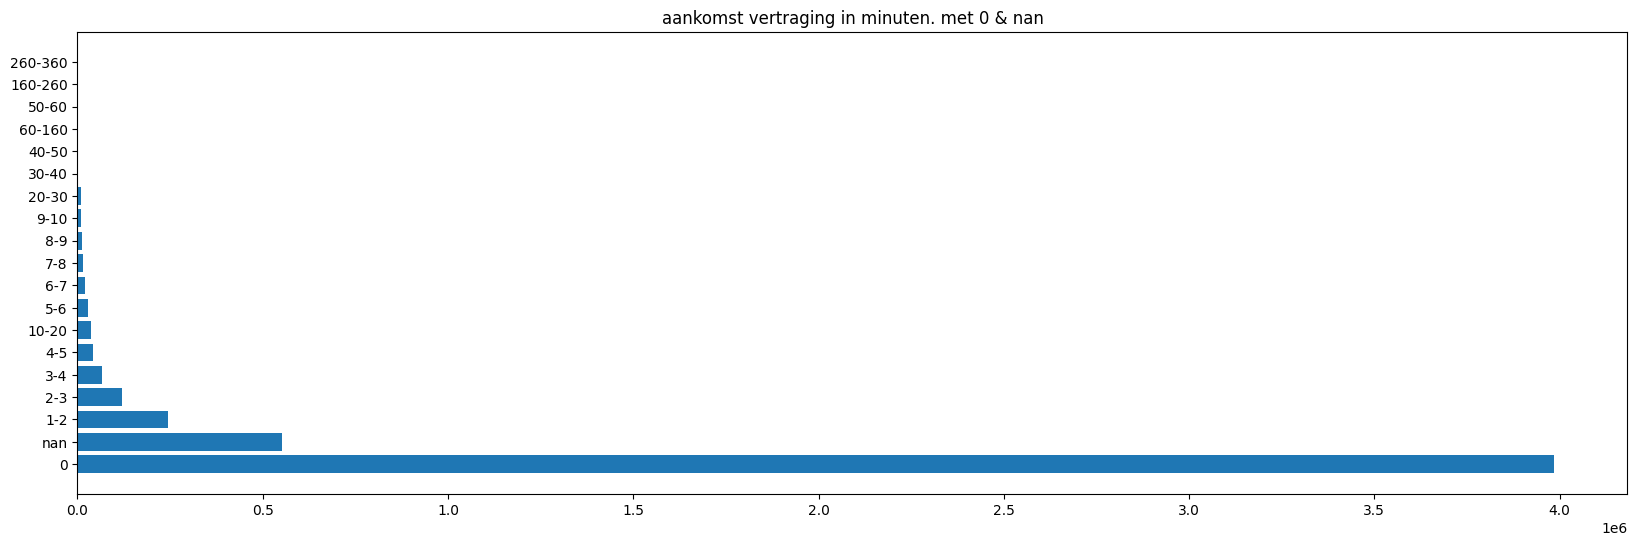

In [11]:
bins = list(range(1, 10, 1)) + list(range(10, 60, 10)) + list(range(60, int(Train_trafic_2023['Stop:Arrival delay'].max()) +100, 100))

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

counts = pd.cut(Train_trafic_2023['Stop:Arrival delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

labels = ['0'] + labels 

bins = [0] + bins

counts = pd.cut(Train_trafic_2023['Stop:Arrival delay'], bins=bins, labels=labels, include_lowest=True).astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. met 0 & nan')
plt.show()

Als ik naar wat de vier chards zeggen lijken ze goed overeen te komen. Dit betekend dat meestal als een trein te laat binnen komt zal hij waarschijnlijk ook te laat vertrekken.

Met de table tabel hieronder zal ik kijken of er op een bepaalde lijn meer vertraging is dan op een ander. Hiervoor moet ik wel oppassen en kijken of ik niet te vaak de zelfde lijn meenemen. \
Aangezien der is aangegeven dat een RDT-ID meerdere keren kan voorkomen op verschillende dagen moet ik eerst even alles goed bij elkaar zetten. \
En ik pak de mean omdat ik de average vertraging van de ritten op een dag zien.

Service:Date  Stop:Arrival delay
0    2023-01-01            0.680368
1    2023-01-02            0.596654
2    2023-01-03            0.565669
3    2023-01-04            0.781114
4    2023-01-05            0.673781
..          ...                 ...
85   2023-03-27            0.799672
86   2023-03-28            0.964126
87   2023-03-29            0.642580
88   2023-03-30            0.710096
89   2023-03-31            0.702228

[90 rows x 2 columns]

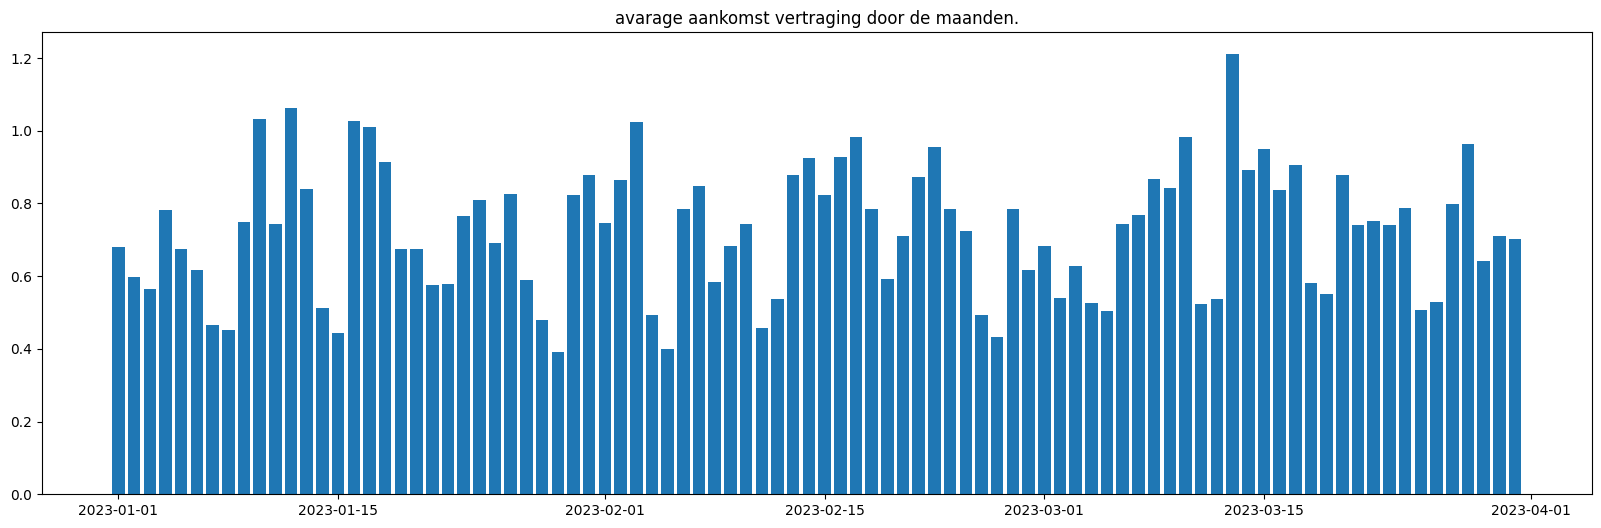

In [12]:
grouped = Train_trafic_2023.groupby(['Service:Date', 'Service:RDT-ID'])['Stop:Arrival delay'].mean()

df_avarage_delay_day = grouped.reset_index(name='Stop:Arrival delay')

grouped = df_avarage_delay_day.groupby(['Service:Date'])['Stop:Arrival delay'].mean()

df_avarage_delay_day = grouped.reset_index(name='Stop:Arrival delay')

display(df_avarage_delay_day)

plt.figure(figsize=(20,6))
plt.bar( df_avarage_delay_day['Service:Date'], df_avarage_delay_day['Stop:Arrival delay'])
plt.title(label='avarage aankomst vertraging door de maanden.')
plt.show()

In te grafiek hierboven is te zien dat de gemiddelde aankomst vertraging schommelt door de maanden. \
Dit kan belangrijk zijn voor het testen van omstandigheden met het weer.

### 🌥️ Het weer
In het weer bestaan veel Kolommen en ik kijk even wat er nodig is en wat niet. Daarvoor ga ik het gemiddelde berekenen en kijken hoe ver ik daarmee van het antwoord. Als het in de buurt zit kan ik zeggen dat het gemiddelde goed is voor heel Nederland, Als het niet zo is moet ik even kijken wat ik dan ga doen.


In [13]:
grouped = weather_2023.groupby(by=['start_time']).mean()

db_weather_single_day = grouped.reset_index()

db_weather_single_day = db_weather_single_day.drop(columns=['STN'])

display(db_weather_single_day.head(24))

df_first_date = weather_2023[weather_2023['start_time'] == weather_2023['start_time'].min()]

display(df_first_date[df_first_date['temp'].notna()].sort_values('temp'))


start_time          DD          FH          FF          FX  \
0  2023-01-01 00:00:00+01:00  215.555556  110.666667  110.000000  172.222222   
1  2023-01-01 01:00:00+01:00  215.333333  108.000000  106.444444  167.333333   
2  2023-01-01 02:00:00+01:00  220.222222  107.333333  106.888889  168.000000   
3  2023-01-01 03:00:00+01:00  223.111111  104.000000  103.333333  165.111111   
4  2023-01-01 04:00:00+01:00  224.444444   99.111111   99.111111  158.444444   
5  2023-01-01 05:00:00+01:00  224.666667   95.333333   94.222222  148.444444   
6  2023-01-01 06:00:00+01:00  224.666667   91.333333   89.555556  140.222222   
7  2023-01-01 07:00:00+01:00  222.666667   87.111111   83.777778  134.444444   
8  2023-01-01 08:00:00+01:00  219.111111   81.777778   81.555556  127.555556   
9  2023-01-01 09:00:00+01:00  215.111111   76.666667   76.444444  119.555556   
10 2023-01-01 10:00:00+01:00  216.222222   78.444444   80.222222  120.000000   
11 2023-01-01 11:00:00+01:00  218.444444   78.666667   77.777778  122.888889   
12 2023-01-01 12:00:00+01:00  218.666667   77.555556   74.222222  119.555556   
13 2023-01-01 13:00:00+01:00  212.222222   68.000000   63.777778  107.555556   
14 2023-01-01 14:00:00+01:00  201.555556   59.111111   54.888889   92.666667   
15 2023-01-01 15:00:00+01:00  190.000000   52.000000   49.777778   82.000000   
16 2023-01-01 16:00:00+01:00  182.000000   48.888889   49.777778   76.666667   
17 2023-01-01 17:00:00+01:00  176.000000   49.111111   49.555556   78.222222   
18 2023-01-01 18:00:00+01:00  172.000000   49.333333   49.555556   78.444444   
19 2023-01-01 19:00:00+01:00  173.555556   48.222222   48.222222   78.222222   
20 2023-01-01 20:00:00+01:00  187.333333   41.333333   40.666667   76.222222   
21 2023-01-01 21:00:00+01:00  167.555556   40.444444   40.000000   73.777778   
22 2023-01-01 22:00:00+01:00  172.000000   41.777778   43.555556   70.000000   
23 2023-01-01 23:00:00+01:00  171.777778   43.777778   42.444444   72.444444   

          temp        T10N         TD       SQ         Q  ...     VV     N  \
0   140.617647         NaN  80.382353  0.00000   0.00000  ...  73.28  8.00   
1   138.029412         NaN  80.764706  0.00000   0.00000  ...  74.28  8.00   
2   135.529412         NaN  79.941176  0.00000   0.00000  ...  74.12  8.00   
3   131.323529         NaN  80.911765  0.00000   0.00000  ...  73.20  7.95   
4   125.970588         NaN  79.970588  0.00000   0.00000  ...  73.88  8.00   
5   122.558824  114.294118  76.294118  0.00000   0.00000  ...  73.08  8.00   
6   117.941176         NaN  75.352941  0.00000   0.00000  ...  70.80  8.00   
7   113.647059         NaN  75.970588  0.00000   0.25000  ...  69.88  8.00   
8   112.441176         NaN  78.558824  0.18750   5.62500  ...  69.40  8.00   
9   114.911765         NaN  81.676471  2.62500  25.12500  ...  69.56  8.00   
10  118.764706         NaN  83.588235  3.25000  40.75000  ...  70.64  7.90   
11  120.529412  102.852941  84.882353  1.46875  42.56250  ...  71.48  7.95   
12  121.382353         NaN  84.088235  2.00000  38.59375  ...  71.24  8.00   
13  119.647059         NaN  83.529412  1.06250  23.28125  ...  71.04  8.00   
14  116.352941         NaN  83.352941  1.15625  10.03125  ...  70.52  8.00   
15  113.617647         NaN  83.647059  0.00000   1.18750  ...  69.88  8.00   
16  111.058824         NaN  86.264706  0.00000   0.00000  ...  68.64  8.00   
17  108.735294  100.294118  89.058824  0.00000   0.00000  ...  67.32  8.00   
18  105.764706         NaN  92.147059  0.00000   0.00000  ...  65.08  8.00   
19  104.058824         NaN  93.617647  0.00000   0.00000  ...  62.68  8.00   
20  101.941176         NaN  93.500000  0.00000   0.00000  ...  60.88  8.00   
21  102.264706         NaN  94.764706  0.00000   0.00000  ...  61.36  8.00   
22  105.029412         NaN  95.470588  0.00000   0.00000  ...  60.68  8.00   
23  107.970588   95.647059  96.911765  0.00000   0.00000  ...  59.48  8.00   

            U         WW        IX    M     R    S    O    Y  
0  

STN                start_time     DD     FH     FF     FX   temp  T10N  \
17280  251 2023-01-01 00:00:00+01:00  220.0  140.0  130.0  190.0  108.0   NaN   
6480   235 2023-01-01 00:00:00+01:00  220.0  120.0  120.0  180.0  112.0   NaN   
10800  242 2023-01-01 00:00:00+01:00  220.0  160.0  150.0  210.0  114.0   NaN   
25920  267 2023-01-01 00:00:00+01:00  220.0  130.0  130.0  200.0  121.0   NaN   
19440  257 2023-01-01 00:00:00+01:00    NaN    NaN    NaN    NaN  123.0   NaN   
49680  286 2023-01-01 00:00:00+01:00  210.0  110.0  100.0  170.0  128.0   NaN   
36720  277 2023-01-01 00:00:00+01:00  220.0  120.0  130.0  200.0  130.0   NaN   
32400  273 2023-01-01 00:00:00+01:00  220.0   80.0   70.0  130.0  131.0   NaN   
56160  310 2023-01-01 00:00:00+01:00  200.0  140.0  140.0  180.0  131.0   NaN   
30240  270 2023-01-01 00:00:00+01:00  230.0  140.0  140.0  230.0  132.0   NaN   
43200  280 2023-01-01 00:00:00+01:00  210.0  110.0  100.0  190.0  133.0   NaN   
73440  330 2023-01-01 00:00:00+01:00  210.0  130.0  120.0  210.0  135.0   NaN   
15120  249 2023-01-01 00:00:00+01:00  230.0  140.0  130.0  230.0  136.0   NaN   
8640   240 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  150.0  138.0   NaN   
41040  279 2023-01-01 00:00:00+01:00  220.0   90.0   90.0  150.0  139.0   NaN   
28080  269 2023-01-01 00:00:00+01:00  220.0  100.0  110.0  170.0  141.0   NaN   
2160   215 2023-01-01 00:00:00+01:00  220.0  110.0  130.0  200.0  142.0   NaN   
79920  344 2023-01-01 00:00:00+01:00  210.0  100.0  110.0  180.0  143.0   NaN   
66960  319 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  180.0  145.0   NaN   
69120  323 2023-01-01 00:00:00+01:00  210.0   90.0   90.0  160.0  145.0   NaN   
95040  380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
82080  348 2023-01-01 00:00:00+01:00  220.0  120.0  130.0  180.0  147.0   NaN   
75600  340 2023-01-01 00:00:00+01:00  220.0   70.0   80.0  140.0  148.0   NaN   
38880  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
86400  356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
51840  290 2023-01-01 00:00:00+01:00  210.0   80.0   70.0  150.0  152.0   NaN   
34560  275 2023-01-01 00:00:00+01:00  220.0  100.0   90.0  150.0  153.0   NaN   
45360  283 2023-01-01 00:00:00+01:00  210.0   70.0   70.0  130.0  154.0   NaN   
84240  350 2023-01-01 00:00:00+01:00  210.0   90.0   90.0  150.0  154.0   NaN   
23760  260 2023-01-01 00:00:00+01:00  220.0   80.0  100.0  160.0  155.0   NaN   
92880  377 2023-01-01 00:00:00+01:00  210.0   90.0   80.0  160.0  155.0   NaN   
90720  375 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  160.0  162.0   NaN   
88560  370 2023-01-01 00:00:00+01:00  220.0  110.0  120.0  190.0  163.0   NaN   
97200  391 2023-01-01 00:00:00+01:00  220.0   50.0   50.0  120.0  163.0   NaN   

         TD   SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
17280  88.0  0.0  ...  58.0  NaN  87.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
6480   95.0  0.0  ...  56.0  8.0  89.0  52.0   7  0.0  1.0  0.0  0.0  0.0  
10800  91.0  NaN  ...  57.0  8.0  86.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
25920  89.0  0.0  ...  64.0  8.0  81.0  57.0   7  0.0  1.0  0.0  0.0  0.0  
19440  83.0  0.0  ...   NaN  NaN  76.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
49680  98.0  0.0  ...   NaN  NaN  82.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
36720  92.0  0.0  ...   NaN  NaN  78.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
32400  93.0  0.0  ...  64.0  NaN  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
56160  79.0  0.0  ...  75.0  8.0  70.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
30240  94.0  0.0  ...  74.0  8.0  78.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
43200  94.0  0.0  ...  71.0  8.0  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
73440  78.0  0.0  ...   NaN  NaN  68.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
15120  98.0  0.0  ...  63.0  NaN  77.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
8640   92.0  0.0  ...  69.0  8.0  73.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
41040  92.0  0.0  ...  75.0  8.

Het ziet er naar out dat met de temperatuur het er uit ziet dat er een ~4 grade verschil tussen de hoogste en laagste temperatuur. \
En terwijl 4 grade verschil niet veel is kan het er tot leiden dat mijn data niet meer klopt. Dus het ziet er naar uit dat ik toch het verschil tussen de stations moet vinden en de dichtstbijzijnde weer station. \
En dan ook nog rekening houden met de tijd van meting.

### 🏟️ Trein station 

Ik moet als eerst erachter komen welke trein stations ik nodig heb voor mijn datasets. En dat is wat ik hieronder doe. \
Ik pak de station codes van het trein verkeer en de codes van de train station in de locatie dataset en kijk welke er in zitten.

In [14]:
train_station_locations = train_station_locations[train_station_locations['code'].isin(Train_trafic_2023['Stop:Station code'])]

display(train_station_locations)

id  code      uic  name_short       name_medium              name_long  \
0    266    HT  8400319   Den Bosch  's-Hertogenbosch       's-Hertogenbosch   
1    269   HTO  8400320  Dn Bosch O  's-Hertogenb. O.  's-Hertogenbosch Oost   
2    227   HDE  8400388    't Harde          't Harde               't Harde   
3      8  AHBF  8015345      Aachen        Aachen Hbf             Aachen Hbf   
4    818    AW  8015199    Aachen W       Aachen West            Aachen West   
..   ...   ...      ...         ...               ...                    ...   
585  677   ZUE  8503000   Zürich HB         Zürich HB              Zürich HB   
586  534    ZP  8400744     Zutphen           Zutphen                Zutphen   
587  541   ZWD  8400752  Zwijndrcht       Zwijndrecht            Zwijndrecht   
589  532    ZL  8400747      Zwolle            Zwolle                 Zwolle   
590  815  ZLSH  8400746  Stadshagen        Stadshagen      Zwolle Stadshagen   

                     slug country                       type    geo_lat  \
0         s-hertogenbosch      NL  knooppuntIntercitystation  51.690480   
1    s-hertogenbosch-oost      NL           stoptreinstation  51.700554   
2                 t-harde      NL           stoptreinstation  52.409168   
3              aachen-hbf       D  knooppuntIntercitystation  50.767800   
4             aachen-west       D           stoptreinstation  50.780360   
..                    ...     ...                        ...        ...   
585             zurich-hb      CH           intercitystation  47.378190   
586               zutphen      NL  knooppuntIntercitystation  52.145279   
587           zwijndrecht      NL           stoptreinstation  51.814999   
589                zwolle      NL  knooppuntIntercitystation  52.504723   
590     zwolle-stadshagen      NL           stoptreinstation  52.527640   

      geo_lng  
0    5.293620  
1    5.318333  
2    5.893611  
3    6.091499  
4    6.070715  
..        ...  
585  8.539200  
586  6.194167  
587  4.641667  
589  6.091944  
590  6.051460  

[546 rows x 11 columns]

Met deze informatie kan ik mijn trein stations coördinaten geven zodat ik de dichtstbijzijnde weer station kan gebruiken.

Maar om dat te testen doe ik hier eerst een test gebaseerd op 1 meetpunt moment.

Hier gebruik ik de BellTree functie van de neighbors functies van sklearn. Hiermee probeer ik de tempraturen van de stations te ontdekken.

De metric haversine is een goede metric omdat de afstand tussen twee locaties uit te calculeren.

Ik moet allen voor de haversine metric de ingaande informatie omzetten naar de radians vorm, gelukkig heeft numpy daar een goede functie voor.

Uiteindelijk doe ik dit om een zo dicht mogelijk weer station te krijgen. Want dit heb ik nodig om te bepalen of de trein verkeer vertragingen een verbinding hebben met het weer.

In [15]:
from sklearn.neighbors import BallTree

df_mergid_first_date_stations = df_first_date.merge(weather_station_location, on='STN', how='inner')

df_mergid_first_date_stations[['LAT(north)_radians', 'LON(east)_radians']] = np.radians(df_mergid_first_date_stations[['LAT(north)', 'LON(east)']])
train_station_locations[['geo_lat_radians', 'geo_lng_radians']] = np.radians(train_station_locations[['geo_lat', 'geo_lng']])

tree = BallTree(df_mergid_first_date_stations[['LAT(north)_radians', 'LON(east)_radians']].dropna().values, metric='haversine')

indices = tree.query(train_station_locations[['geo_lat_radians', 'geo_lng_radians']].dropna().values, return_distance=False, k=1)

nearest_neighbors_weather_station_location = df_mergid_first_date_stations.iloc[indices.flatten()]

train_station_locations.reset_index(drop=True, inplace=True)
nearest_neighbors_weather_station_location.reset_index(drop=True, inplace=True)

combined_df = pd.concat([nearest_neighbors_weather_station_location, train_station_locations], axis=1)

display(combined_df.drop(columns=['geo_lat_radians', 'geo_lng_radians', 'LAT(north)_radians', 'LON(east)_radians', 'name_short', 'name_medium', 'name_long', 'id', 'code', 'uic']))


STN                start_time     DD     FH     FF     FX   temp  T10N  \
0    356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
1    356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
2    278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
3    380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
4    380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
..   ...                       ...    ...    ...    ...    ...    ...   ...   
541  380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
542  275 2023-01-01 00:00:00+01:00  220.0  100.0   90.0  150.0  153.0   NaN   
543  344 2023-01-01 00:00:00+01:00  210.0  100.0  110.0  180.0  143.0   NaN   
544  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
545  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   

       TD   SQ  ...    Y  LON(east)  LAT(north)  ALT(m)        NAME  \
0    80.0  0.0  ...  NaN      5.146      51.859     0.7   Herwijnen   
1    80.0  0.0  ...  NaN      5.146      51.859     0.7   Herwijnen   
2    83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   
3    42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
4    42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
..    ...  ...  ...  ...        ...         ...     ...         ...   
541  42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
542  76.0  0.0  ...  0.0      5.873      52.056    48.2      Deelen   
543  88.0  0.0  ...  0.0      4.447      51.962    -4.3   Rotterdam   
544  83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   
545  83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   

                     slug  country                       type    geo_lat  \
0         s-hertogenbosch       NL  knooppuntIntercitystation  51.690480   
1    s-hertogenbosch-oost       NL           stoptreinstation  51.700554   
2                 t-harde       NL           stoptreinstation  52.409168   
3              aachen-hbf        D  knooppuntIntercitystation  50.767800   
4             aachen-west        D           stoptreinstation  50.780360   
..                    ...      ...                        ...        ...   
541             zurich-hb       CH           intercitystation  47.378190   
542               zutphen       NL  knooppuntIntercitystation  52.145279   
543           zwijndrecht       NL           stoptreinstation  51.814999   
544                zwolle       NL  knooppuntIntercitystation  52.504723   
545     zwolle-stadshagen       NL           stoptreinstation  52.527640   

      geo_lng  
0    5.293620  
1    5.318333  
2    5.893611  
3    6.091499  
4    6.070715  
..        ...  
541  8.539200  
542  6.194167  
543  4.641667  
544  6.091944  
545  6.051460  

[546 rows x 33 columns]

Uit de test hierboven can ik valideren dat ik met de weer stations en trein station locaties, Redelijk goed de dichtstbijzijnde weerstation van een trein station kan vinden.

# 🎛️ correlatie bekijken.

Hier ga ik de correlatie plots van de datasets neerzetten.

### 🚄 Trein verkeer 
Dit is de correlatie plot van het trein verkeer

<Axes: >

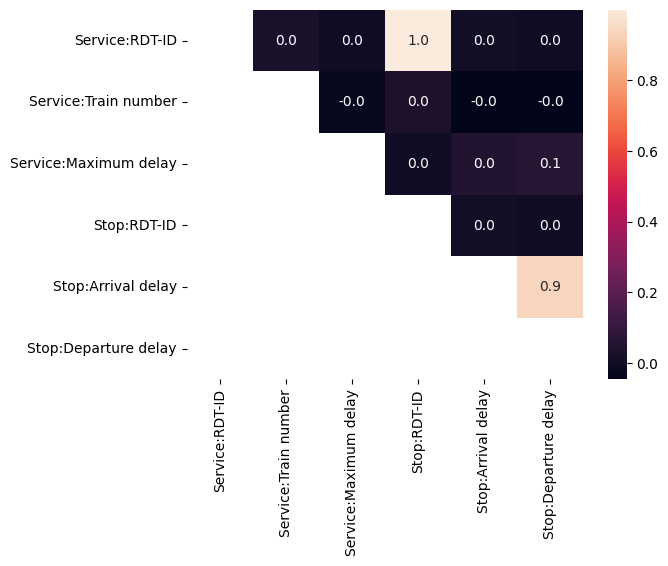

In [16]:
corr = Train_trafic_2023.select_dtypes(include=['int32', 'int64', 'float64']).corr()

mask = np.tril(corr);

sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f")

Het ziet er naar uit als ik de losse trein informatie cor plot geeft het een lage correlatie met elkaar. \
Hieronder ga ik een pairplot maken om te kijken of ik er iets meer uit kan maken.

<Figure size 2000x2000 with 0 Axes>

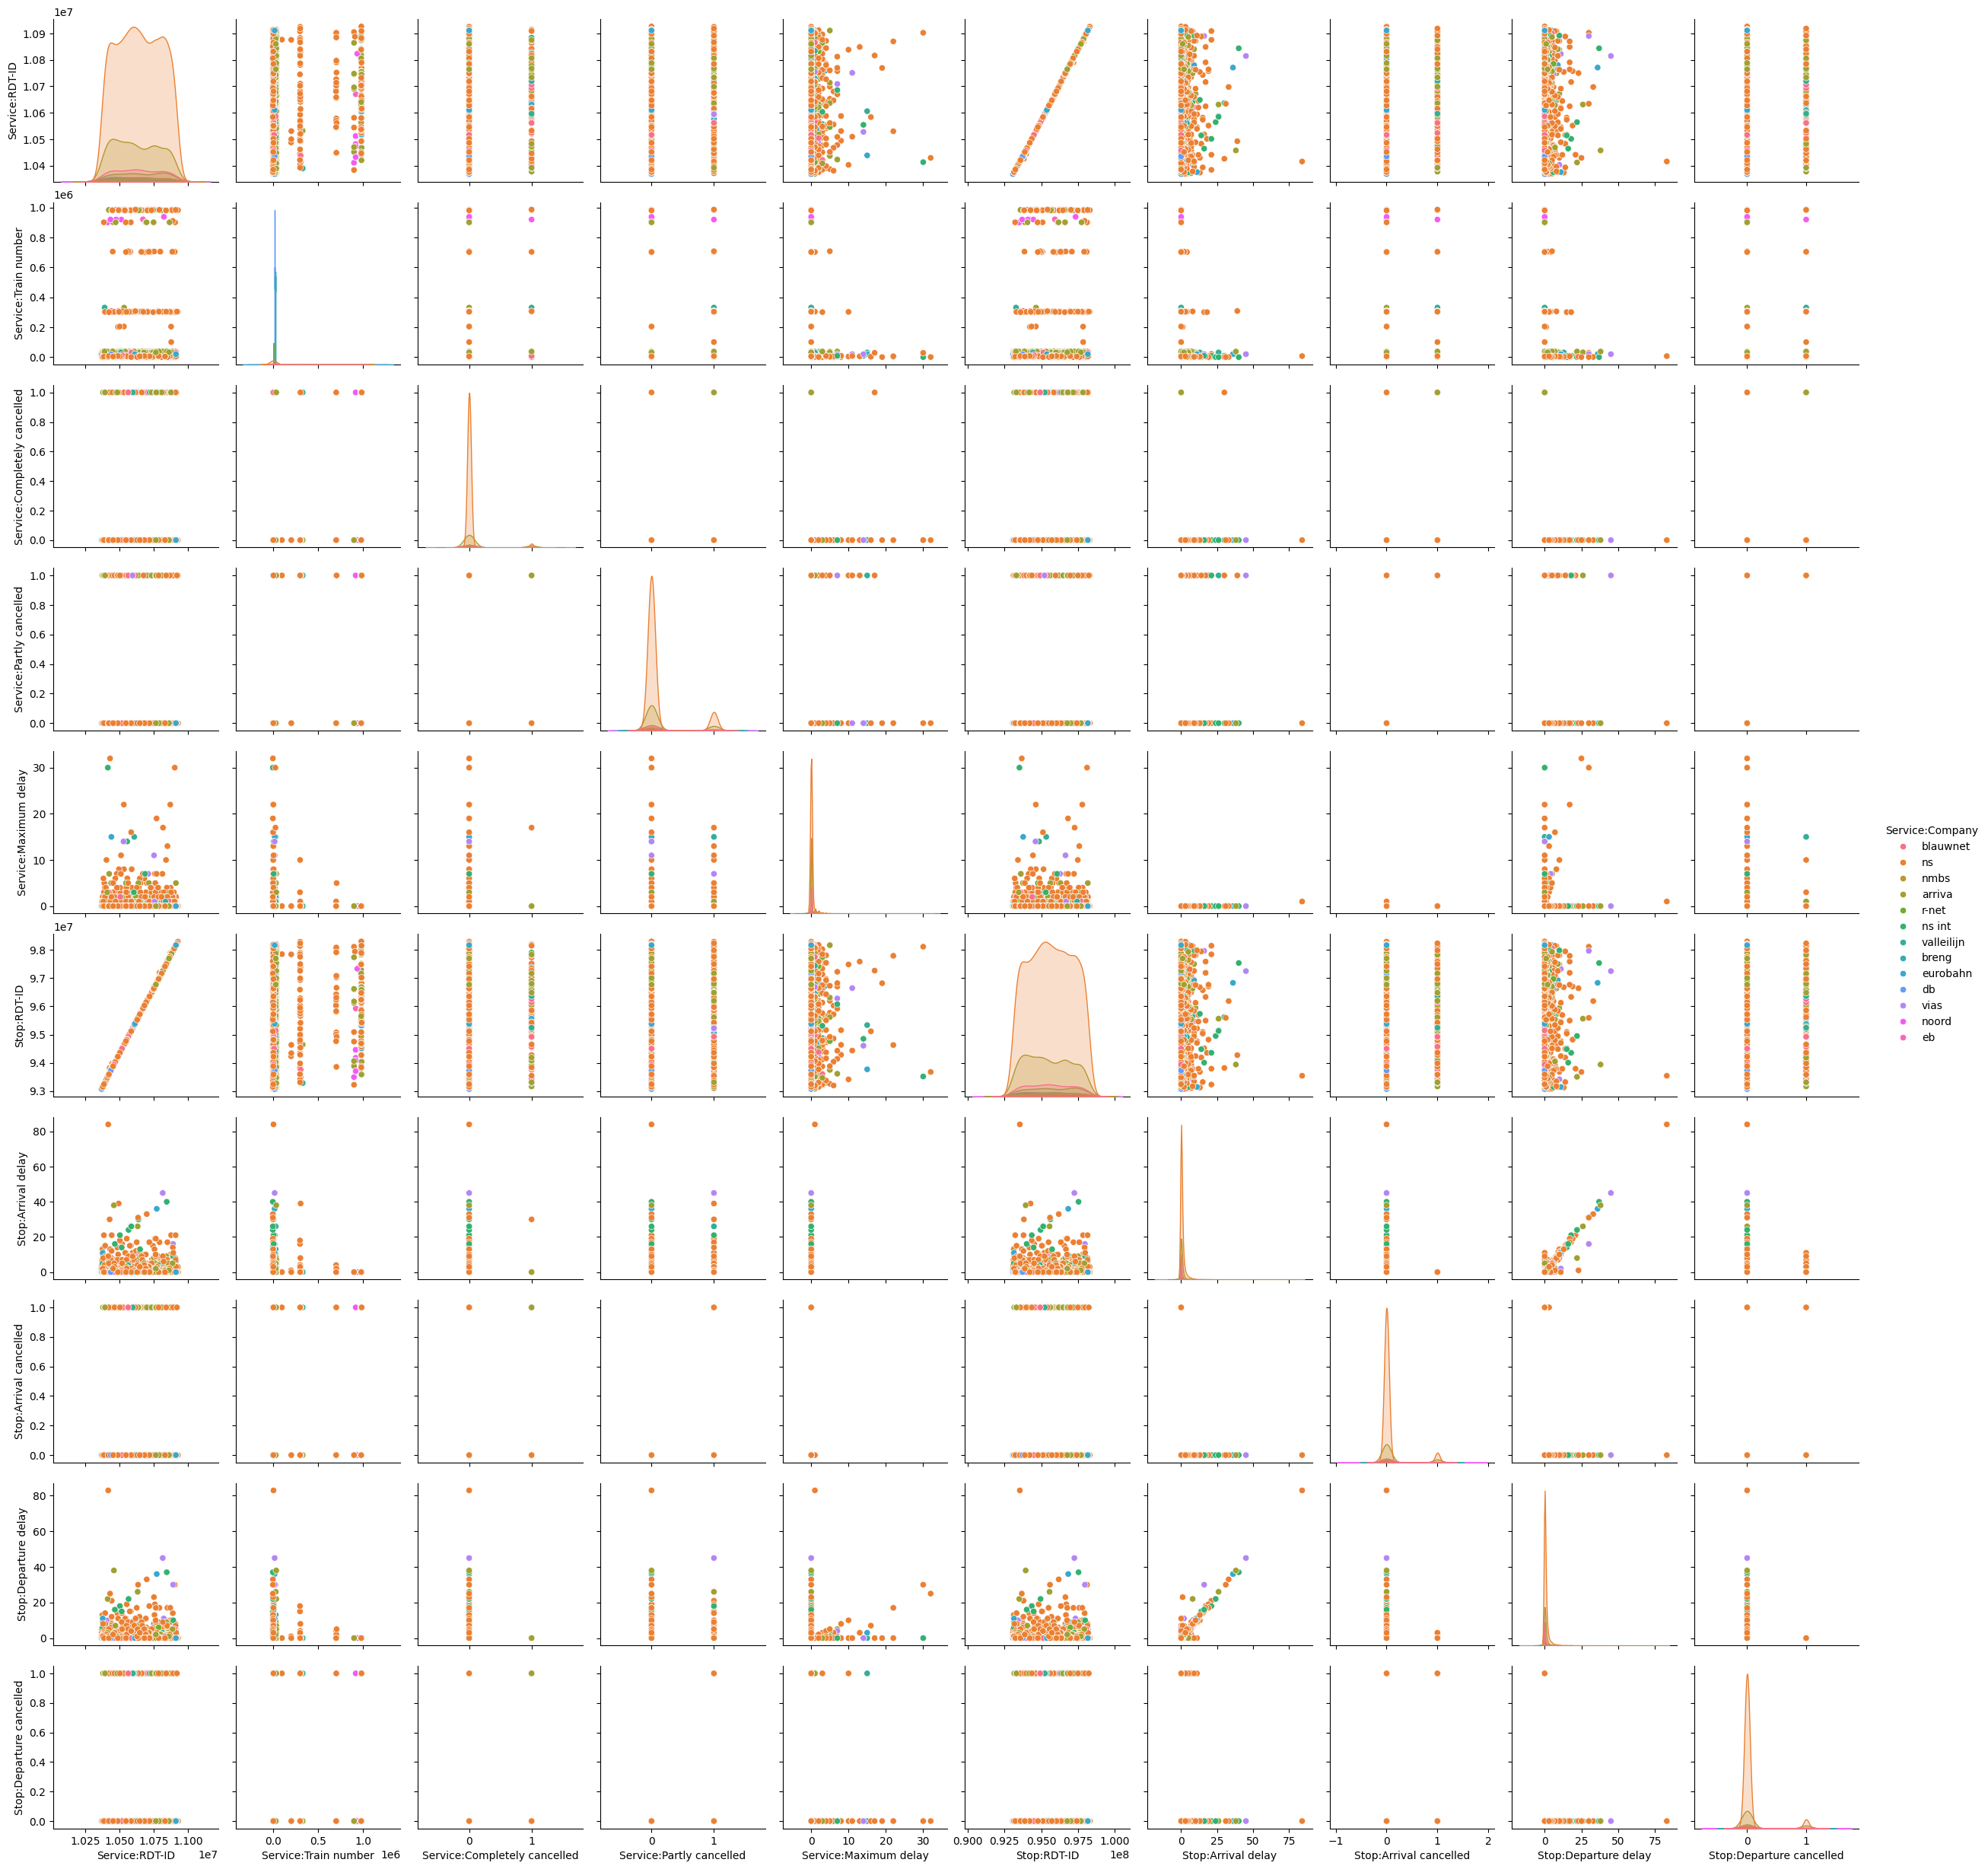

In [17]:
plt.figure(figsize=(20,20))
sns.pairplot(Train_trafic_2023.sample(frac=0.001), hue='Service:Company')

Terwijl ik de hoeveelheid heb moeten verkleinen krijg ik er well een goed gevoel over wat er in mijn dataset zit.

### 🌥️ het weer

<Axes: >

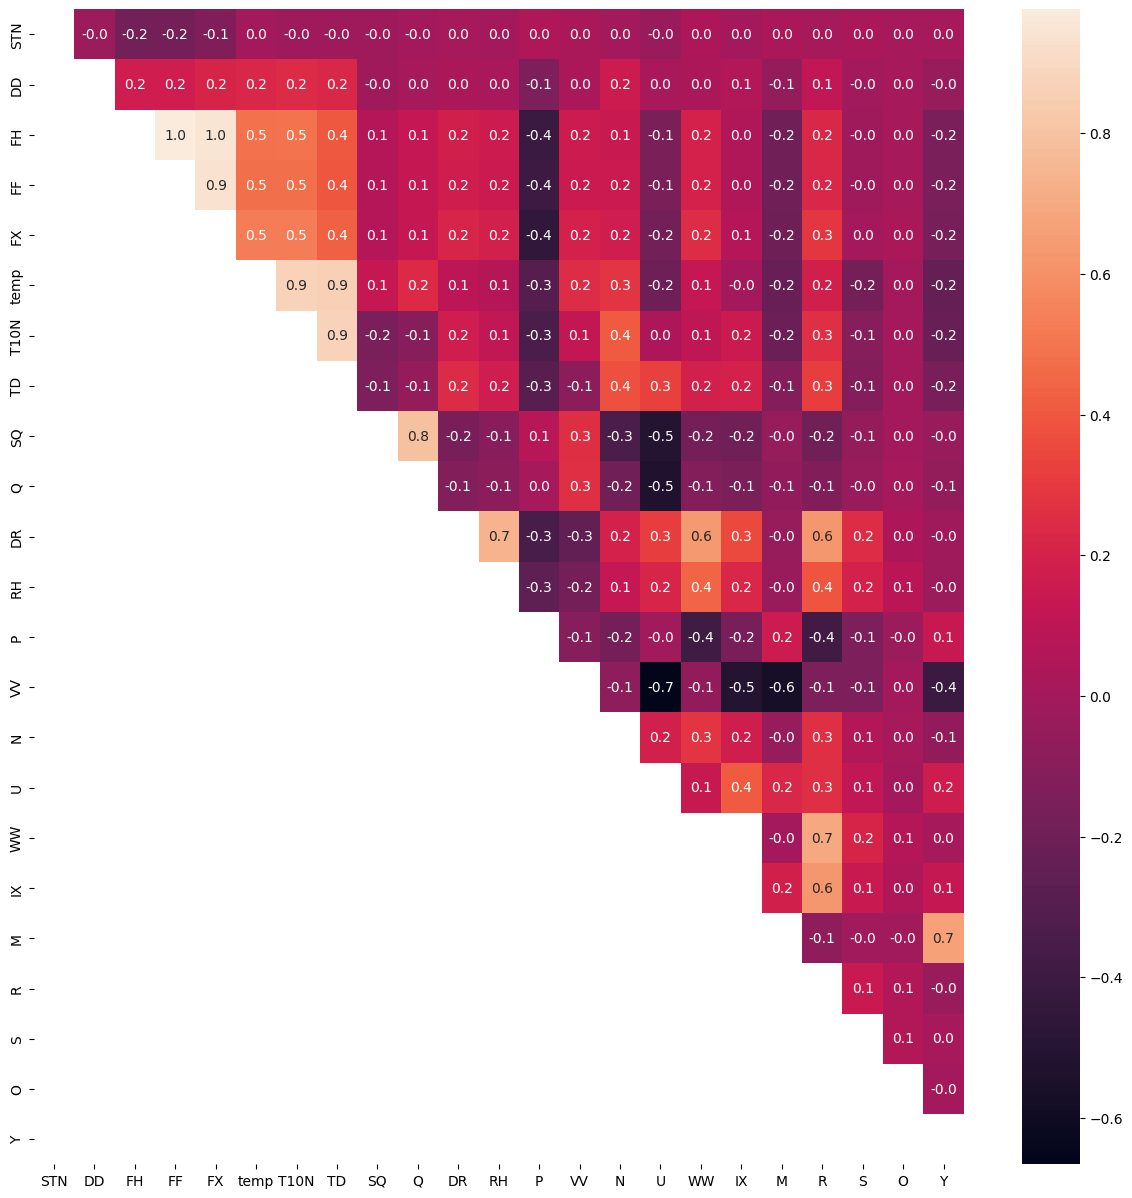

In [18]:
plt.subplots(figsize=(15, 15))

corr = weather_2023.select_dtypes(include=['int32', 'int64', 'float64']).corr()
mask = np.tril(corr);
sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f",)

Het ziet er naar uit dat het weer een grote relatie heeft met elkaar. Niet alleen even veel maar de dingen die met elkaar te maken horen te hebben doen. Zoals de temperatuur en de minimale temperatuur elk 6 uur hebben een grote correlatie.

STN                start_time     DD    FH    FF     FX   temp  T10N  \
21270  257 2023-03-18 06:00:00+01:00    NaN   NaN   NaN    NaN  103.0   NaN   
93239  377 2023-01-15 23:00:00+01:00  220.0  70.0  60.0  100.0   57.0  40.0   
2087   209 2023-03-28 23:00:00+02:00  180.0  90.0  80.0  110.0    NaN   NaN   
60477  312 2023-03-31 21:00:00+02:00  280.0  80.0  70.0  110.0    NaN   NaN   
19929  257 2023-01-21 09:00:00+01:00    NaN   NaN   NaN    NaN   -3.0   NaN   
...    ...                       ...    ...   ...   ...    ...    ...   ...   
28221  269 2023-01-06 21:00:00+01:00  210.0  50.0  60.0   80.0  107.0   NaN   
9196   240 2023-01-24 04:00:00+01:00   80.0  40.0  50.0   70.0   28.0   NaN   
33     209 2023-01-02 09:00:00+01:00  240.0  70.0  70.0   90.0    NaN   NaN   
46968  283 2023-03-09 00:00:00+01:00   50.0  40.0  30.0   60.0    1.0   NaN   
66069  316 2023-02-22 21:00:00+01:00  220.0  20.0  10.0   20.0    NaN   NaN   

         TD   SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
21270  83.0  0.0  ...   NaN  NaN  87.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
93239  29.0  0.0  ...  70.0  8.0  82.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
2087    NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
60477   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
19929  -3.0  0.0  ...   NaN  NaN  99.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
...     ...  ...  ...   ...  ...   ...   ...  ..  ...  ...  ...  ...  ...  
28221  99.0  0.0  ...  63.0  8.0  94.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
9196   -2.0  0.0  ...  75.0  8.0  80.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
33      NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
46968  -1.0  0.0  ...   NaN  NaN  99.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
66069   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  

[99 rows x 24 columns]

<Figure size 2000x2000 with 0 Axes>

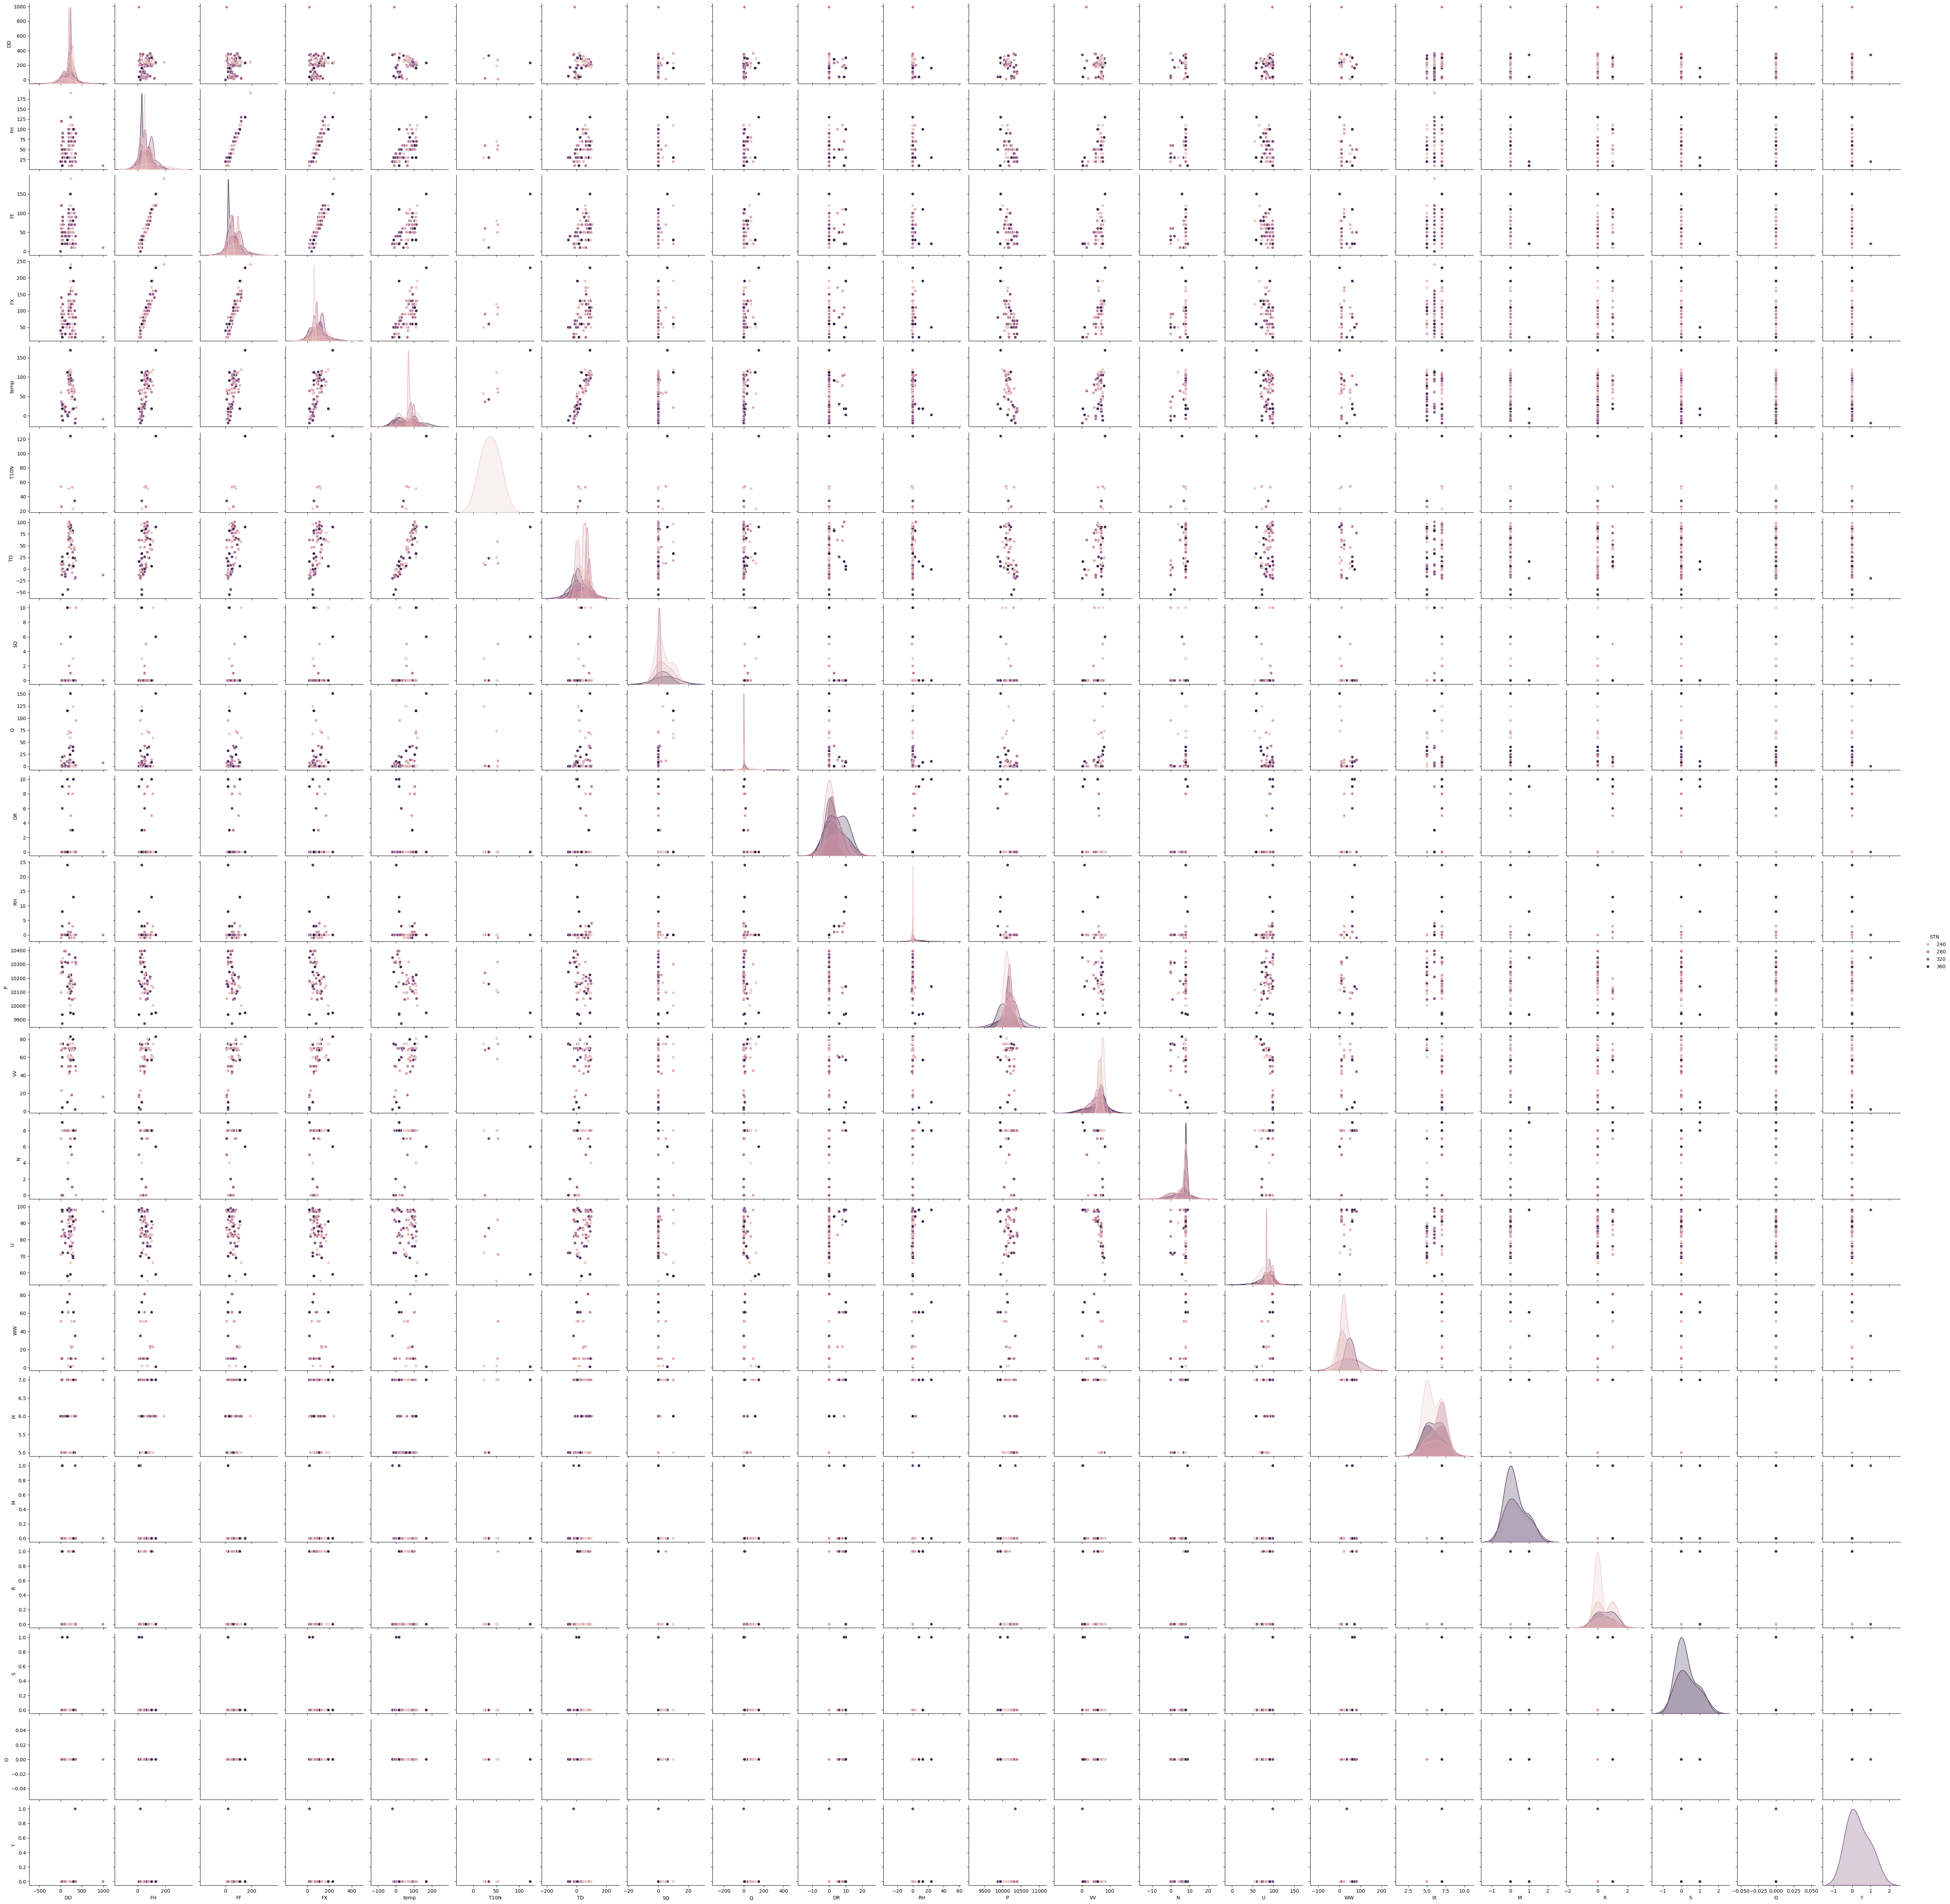

In [19]:
plt.figure(figsize=(20,20))
display(weather_2023.sample(frac=0.001))
sns.pairplot(weather_2023.sample(frac=0.001), hue='STN')

### 🏟️ trein station 

<Axes: >

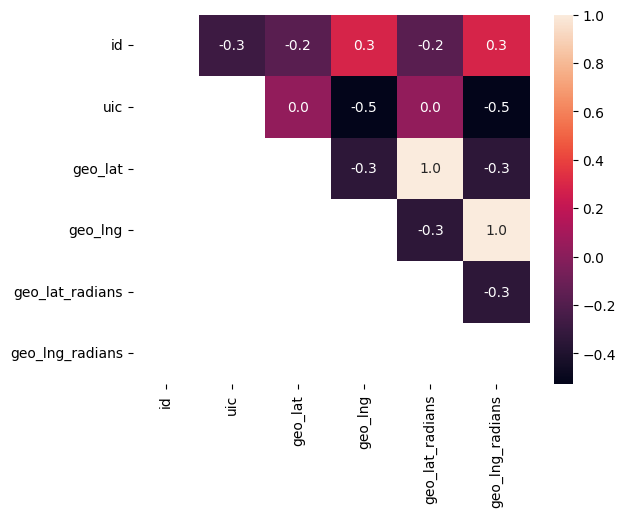

In [20]:
corr = train_station_locations.select_dtypes(include=['int32', 'int64', 'float64']).corr()
mask = np.tril(corr);
sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f")

Dit was meer om te kijken of ik iets kreeg. maar het geeft een goed voorbeeld van de gegevens.

# 🛠️ Preprocessing

Hier ga ik kijken of ik de datasets kan samenvoegen, Zodat ik 1 volledige dataset krijg met mijn informatie. \
En waar natuurlijk de data op de juiste plek sta.

### 🚄&🏟️ trein verkeer samenvoegen met trein station.
Hieronder ga ik al het verkeer verzien van hun trein station gegevens. Zodat ik het later samen kan voegen met het juiste weerstation. \
Hiervoor ga ik een nieuwe variable aanmaken zodat ik hem ook meerdere keren kan draaien zonder dat het de data hierboven verpest. \
De samenvoeging zal worden gedaan door de twee datasets te joinen met de merge functie van Panda's, De join zal alles van beiden tabellen hebben.\
Ik gebruik in de merge de stations code die in beide tabellen voorkomen, Al heten ze anders het zijn allebei de stations code. \
Dit zal als het goed is niet de moeilijkste moeten zijn want de datasets komen van de zelfde provider.

In [21]:
# train_station_locations , Train_trafic_2023
display(
   train_station_locations[train_station_locations['name_short']== "Nw A'dam"] 
)
train_trafic_with_locations = Train_trafic_2023.merge(right=train_station_locations, how='outer', left_on='Stop:Station code', right_on='code')
display(train_trafic_with_locations)


id code      uic name_short    name_medium        name_long  \
351  349  NaN  8400454   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   

                slug country              type    geo_lat   geo_lng  \
351  nieuw-amsterdam      NL  sneltreinstation  52.718613  6.848611   

     geo_lat_radians  geo_lng_radians  
351         0.920113         0.119531

Service:RDT-ID Service:Date Service:Type Service:Company  \
0              10368001   2023-01-01     sprinter              ns   
1              10368079   2023-01-01     sprinter              ns   
2              10368089   2023-01-01     sprinter              ns   
3              10368125   2023-01-01     sprinter              ns   
4              10368142   2023-01-01     sprinter              ns   
...                 ...          ...          ...             ...   
5142245        10915642   2023-03-31    stoptrein        blauwnet   
5142246        10915677   2023-03-31    sneltrein        blauwnet   
5142247        10915796   2023-03-31    stoptrein        blauwnet   
5142248        10915874   2023-03-31    stoptrein        blauwnet   
5142249        10915882   2023-03-31    stoptrein        blauwnet   

         Service:Train number  Service:Completely cancelled  \
0                        4026                         False   
1                        4037                         False   
2                        4035                         False   
3                        4030                         False   
4                        4028                         False   
...                       ...                           ...   
5142245                  8092                         False   
5142246                  3879                         False   
5142247                  8081                         False   
5142248                  8096                         False   
5142249                  8083                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                           False                      0     93070750   
1                           False                      0     93071464   
2                           False                      0     93071556   
3                           False                      0     93071943   
4                           False                      0     93072094   
...                           ...                    ...          ...   
5142245                     False                      0     98208124   
5142246                     False                      0     98208425   
5142247                     False                      0     98209348   
5142248                     False                      0     98209890   
5142249                     False                      0     98209958   

        Stop:Station code  ... name_short    name_medium        name_long  \
0                      AC  ...    Abcoude        Abcoude          Abcoude   
1                      AC  ...    Abcoude        Abcoude          Abcoude   
2                      AC  ...    Abcoude        Abcoude          Abcoude   
3                      AC  ...    Abcoude        Abcoude          Abcoude   
4                      AC  ...    Abcoude        Abcoude          Abcoude   
...                   ...  ...        ...            ...              ...   
5142245               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142246               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142247               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142248               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142249               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   

                    slug country              type    geo_lat   geo_lng  \
0                abcoude      NL  stoptreinstation  52.278500  4.977000   
1                abcoude      NL  stoptreinstation  52.278500  4.977000   
2                abcoude      NL  stoptreinstation  52.278500  4.977000   
3                abcoude      NL  stoptreinstation  52.278500  4.977000   
4                abcoude      NL  stoptreinstation  52.278500  4.977000   
...                  ...     ...               ...        ...       ...   
5142245  nieuw-amsterdam      NL  sneltreinstation  52.718613  6.848611   
5142246  nieuw-amster

Voor een deze verbinding ben ik er achter gekomen dat New Amsterdam aan station code heeft die 'NaN' is en niet de geen variabel NaN. \
Maar na dat ging deze verbinding vlekkenloos.

### 🌥️&🚄🏟️ het weer Samenvoegen met de al Samengevoegde treinverkeer met stations.

Met deze moet ik waarschijnlijk machine learning gebruiken om de juiste weerstation aan een station te koppelen. \
Dit is omdat een weerstation ook van tijd kan verschillen en dat heeft invloed op het weer. 

Als eerste ga ik kijken welk weer station het dichts by welk trein station is. 

In [22]:
from sklearn.neighbors import BallTree
import numpy as np

# weather_station_location, train_trafic_with_locations, weather_2023

# Weather_With_location_time = weather_2023.merge(weather_station_location, on='STN', how='inner')

tree = BallTree(np.radians(weather_station_location[['LAT(north)', 'LON(east)']]), metric='haversine')
distances, indices = tree.query(np.radians(train_trafic_with_locations[['geo_lat', 'geo_lng']].dropna()), dualtree=True)

display(distances)
display(indices)
display(weather_2023)

array([[0.00211167],
       [0.00211167],
       [0.00211167],
       ...,
       [0.00295339],
       [0.00295339],
       [0.00295339]])

array([[ 5],
       [ 5],
       [ 5],
       ...,
       [21],
       [21],
       [21]], dtype=int64)

STN                start_time     DD     FH     FF     FX  temp  T10N  \
0      209 2023-01-01 00:00:00+01:00  220.0  140.0  150.0  170.0   NaN   NaN   
1      209 2023-01-01 01:00:00+01:00  220.0  130.0  130.0  170.0   NaN   NaN   
2      209 2023-01-01 02:00:00+01:00  240.0  140.0  130.0  200.0   NaN   NaN   
3      209 2023-01-01 03:00:00+01:00  220.0  120.0  130.0  170.0   NaN   NaN   
4      209 2023-01-01 04:00:00+01:00  230.0  130.0  140.0  170.0   NaN   NaN   
...    ...                       ...    ...    ...    ...    ...   ...   ...   
99355  391 2023-03-31 19:00:00+02:00  210.0   50.0   40.0  120.0  99.0   NaN   
99356  391 2023-03-31 20:00:00+02:00  220.0   40.0   50.0  100.0  99.0   NaN   
99357  391 2023-03-31 21:00:00+02:00  210.0   40.0   40.0  110.0  97.0   NaN   
99358  391 2023-03-31 22:00:00+02:00  220.0   40.0   40.0   90.0  95.0   NaN   
99359  391 2023-03-31 23:00:00+02:00  220.0   50.0   50.0  110.0  94.0  96.0   

         TD   SQ  ...  VV   N     U  WW  IX   M   R   S   O   Y  
0       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
1       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
2       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
3       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
4       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
...     ...  ...  ...  ..  ..   ...  ..  ..  ..  ..  ..  ..  ..  
99355  88.0  0.0  ... NaN NaN  93.0 NaN   6 NaN NaN NaN NaN NaN  
99356  86.0  0.0  ... NaN NaN  91.0 NaN   6 NaN NaN NaN NaN NaN  
99357  87.0  0.0  ... NaN NaN  93.0 NaN   6 NaN NaN NaN NaN NaN  
99358  88.0  0.0  ... NaN NaN  95.0 NaN   6 NaN NaN NaN NaN NaN  
99359  88.0  0.0  ... NaN NaN  95.0 NaN   6 NaN NaN NaN NaN NaN  

[99360 rows x 24 columns]

Hierboven heb ik ervoor gezorgd dat ik weet welk weerstation het dichtstbij een trein station staat. dit heb ik hieronder nodig om een dataset te creëren die alle data van het weer station bij de trein gegevens zet. 

Hieronder ga ik de data samenvoegen zodat ik straks 1 dataset heb waar alles in staat dat ik nodig zou horen te hebben. \
Dit doe ik door een zo dicht mogelijke tijd bij zijn dichtstbijzijnde weerstation te zoeken. \
Ik heb er voor gekozen om voor het testen minder te pakken zodat ik sneller feedback terug krijg van mijn outputs.

In [41]:
combined_data = []


for i, train_station in train_trafic_with_locations.sample(frac=0.005).iterrows():
    
    nearest_weather_station = weather_station_location.iloc[indices[i][0]]
    nearest_weather_station = weather_2023[weather_2023['STN'] == nearest_weather_station.STN]  #pd.merge(weather_station_location[weather_station_location['STN'] == ], weather_2023, on='STN')
    if(nearest_weather_station['start_time'].count() > 0):
        if (pd.notnull(train_station['Stop:Arrival time'])):
            time_diffs = abs(nearest_weather_station['start_time'] - train_station['Stop:Arrival time'])

            nearest_time_index = time_diffs.idxmin()
            nearest_weather_data = nearest_weather_station.loc[nearest_time_index]

            combined_row = pd.concat([train_station, nearest_weather_data])
            combined_data.append(combined_row)

combined_df = pd.DataFrame(combined_data)

combined_df.reset_index(drop=True, inplace=True)

display(combined_df)

Service:RDT-ID Service:Date          Service:Type Service:Company  \
0            10846931   2023-03-21              sprinter              ns   
1            10915844   2023-03-31             stoptrein              db   
2            10774163   2023-03-08              sprinter              ns   
3            10462672   2023-01-17              sprinter        blauwnet   
4            10448692   2023-01-15  stopbus i.p.v. trein              ns   
...               ...          ...                   ...             ...   
21440        10831514   2023-03-18              sprinter              ns   
21441        10540169   2023-01-30             intercity              ns   
21442        10378770   2023-01-03              sprinter              ns   
21443        10590053   2023-02-07              sprinter              ns   
21444        10763475   2023-03-07              sprinter              ns   

       Service:Train number  Service:Completely cancelled  \
0                      4630                         False   
1                     20238                         False   
2                      6156                         False   
3                      7974                         False   
4                    981955                         False   
...                     ...                           ...   
21440                  4643                         False   
21441                  2445                         False   
21442                  5024                         False   
21443                  4445                         False   
21444                  4621                         False   

       Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                         False                      0     97565908   
1                         False                      0     98209692   
2                         False                      0     96865858   
3                          True                      0     93990106   
4                         False                      0     93856576   
...                         ...                    ...          ...   
21440                     False                      0     97415759   
21441                     False                      0     94713244   
21442                     False                      0     93176775   
21443                     False                      0     95179993   
21444                     False                      0     96761199   

      Stop:Station code  ...    VV    N     U    WW IX    M    R    S    O  \
0                  ASSP  ...  74.0  8.0  78.0   2.0  7  0.0  0.0  0.0  0.0   
1                  ENBE  ...  65.0  8.0  93.0  61.0  7  0.0  1.0  0.0  0.0   
2                   VSS  ...  30.0  8.0  93.0  81.0  7  0.0  1.0  0.0  0.0   
3                    BN  ...  75.0  2.0  80.0   NaN  5  0.0  0.0  0.0  0.0   
4                    VB  ...  70.0  1.0  90.0   NaN  5  0.0  0.0  0.0  0.0   
...                 ...  ...   ...  ...   ...   ... ..  ...  ...  ...  ...   
21440              ALMM  ...  75.0  8.0  73.0  57.0  7  0.0  1.0  0.0  0.0   
21441               DDR  ...  65.0  1.0  75.0   NaN  5  0.0  0.0  0.0  0.0   
21442               ZWD  ...  58.0  8.0  98.0  10.0  7  0.0  0.0  0.0  0.0   
21443                DN  ...  80.0  0.0  61.0   NaN  5  0.0  0.0  0.0  0.0   
21444               LLS  ...  65.0  8.0  91.0  23.0  7  0.0  1.0  0.0  0.0   

         Y  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
...    ...  
21440  0.0  
21441  0.0  
21442  0.0  
21443  0.0  
21444  0.0  

[21445 rows x 54 columns]